In [40]:
from collections import defaultdict
import csv
import sys
from shapely import wkt
# from matplotlib.patches import Polygon
import matplotlib.pyplot as plt
import cv2
# from shapely.geometry import MultiPolygon, Polygon
from matplotlib.patches import Polygon
import shapely.wkt
import shapely.affinity
import numpy as np
import tifffile as tiff
import pandas as pd
from PIL import Image
import io
import zipfile
import IPython.display as display
import plotly

import geopandas as gpd
import numpy as np
from shapely.geometry import shape
from rasterio.features import geometry_mask
from shapely.geometry import Point  
import random
import itertools

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
# import torchvision

In [41]:
pip install torchview

Note: you may need to restart the kernel to use updated packages.


In [42]:
from torchview import draw_graph

In [43]:
import plotly.express as px

In [44]:
# model_graph = draw_graph(models.vgg16(pretrained=True), input_size=(1,3,224,224), expand_nested=True)
# model_graph.visual_graph

In [45]:
# IM_ID = '6120_2_2'
# POLY_TYPE = '1'  # buildings

# # Load grid size
# x_max = y_min = None
# for _im_id, _x, _y in csv.reader(open('/kaggle/input/dstl-satellite-imagery-feature-detection/grid_sizes.csv.zip')):
#     if _im_id == IM_ID:
#         x_max, y_min = float(_x), float(_y)
#         break

# # Load train poly with shapely
# train_polygons = None
# for _im_id, _poly_type, _poly in csv.reader(open('/kaggle/input/dstl-satellite-imagery-feature-detection/train_wkt_v4.csv.zip')):
#     if _im_id == IM_ID and _poly_type == POLY_TYPE:
#         train_polygons = shapely.wkt.loads(_poly)
#         break

# # Read image with tiff
# im_rgb = tiff.imread('/kaggle/input/dstl-satellite-imagery-feature-detection/three_band.zip'.format(IM_ID)).transpose([1, 2, 0])
# im_size = im_rgb.shape[:2]

In [46]:
df = pd.read_csv('/kaggle/input/dstl-satellite-imagery-feature-detection/train_wkt_v4.csv.zip')

In [47]:
sizes = pd.read_csv('/kaggle/input/dstl-satellite-imagery-feature-detection/grid_sizes.csv.zip')
sizes = sizes.set_index('Unnamed: 0')

## Visualize one:

<timed exec>:8: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/opt/conda/lib/python3.10/site-packages/IPython/core/magics/execution.py:1325: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



CPU times: user 11 s, sys: 49 ms, total: 11 s
Wall time: 11 s


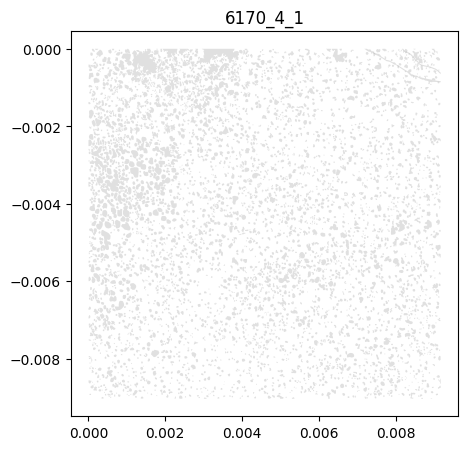

In [48]:
%%time
for ids in ['6170_4_1' ]: #, '6010_4_4', '6140_3_1','6100_1_3', '6170_2_4', '6040_1_3', '6040_2_2', '6170_4_1', '6110_4_0', '6120_2_2', '6100_2_3', '6120_2_0', '6150_2_3', '6110_1_2', '6170_0_4', '6160_2_1', '6090_2_0', '6140_1_2', '6060_2_3', '6110_3_1', '6040_1_0']:
    polygonsList = {}
    image = df[df.ImageId == ids]
    for cType in image.ClassType.unique():
        polygonsList[cType] = wkt.loads(image[image.ClassType == cType].MultipolygonWKT.values[0])
    fig, ax = plt.subplots(figsize=(5, 5))
    for p in polygonsList:
        for polygon in polygonsList[p]:
            mpl_poly = Polygon(np.array(polygon.exterior), color=plt.cm.Set1(p*10), lw=0, alpha=0.3)
            ax.add_patch(mpl_poly)
    ax.relim()
    ax.autoscale_view()
    plt.title(ids)

In [49]:

# df[(df.ImageId=='6120_2_0') & (df.ClassType==4)].MultipolygonWKT
df.MultipolygonWKT[3]

for c in df.ClassType.unique():
    print('class:', c)
    print("num of polygons:", df[(df.ClassType==c) & (df.MultipolygonWKT!='MULTIPOLYGON EMPTY')].MultipolygonWKT.apply(lambda x: x.count(',')).sum())
# df.MultipolygonWKT[3]

class: 1
num of polygons: 97905
class: 2
num of polygons: 200428
class: 3
num of polygons: 2583
class: 4
num of polygons: 75334
class: 5
num of polygons: 1335273
class: 6
num of polygons: 35269
class: 7
num of polygons: 5160
class: 8
num of polygons: 6596
class: 9
num of polygons: 326
class: 10
num of polygons: 5670


## image and mask extraction

In [50]:
def get_scalers(W,H,x_max,y_min):
    h, w = W,H  # they are flipped so that mask_for_polygons works correctly
    w_ = w * (w / (w + 1))
    h_ = h * (h / (h + 1))
    return w_ / x_max, h_ / y_min

def mask_for_polygons(polygons, W,H):
    img_mask = np.zeros((W,H), np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


In [51]:
%%time
ids = df.ImageId.unique()
masks = []
images = []
pickClass = 5 # vegetation
# pickClass = 6 # crops
# pickClass = 2 # structures
# pickClass = 1 # buildins
zip_file_path = '/kaggle/input/dstl-satellite-imagery-feature-detection/three_band.zip'

def get_one_RGBImage_n_label(ID):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_file:
        with zip_file.open('three_band/' + ID + '.tif') as image_file:
            # Read the image using tifffile
            image = tiff.imread(image_file)
            
# Ensure the image has three channels (RGB)
    if image.shape[0] == 3:
        # Transpose the image to (height, width, channels)
        image = np.transpose(image, (1, 2, 0))
    image = image.astype(np.float32) / 2**11  # Assuming the original image is in 16-bit format

#     images.append(image)
    W,H,_ = image.shape        
    
    polygon_str = df[(df.ImageId == ID) & (df.ClassType==pickClass)].MultipolygonWKT.values[0].strip()
    geometry = wkt.loads(polygon_str)
    
    x_scaler, y_scaler = get_scalers(W,H, sizes.loc[ID].Xmax, sizes.loc[ID].Ymin)

    geometry_scaled = shapely.affinity.scale(geometry, xfact=x_scaler, yfact=y_scaler, origin=(0, 0, 0))
    
    train_mask = mask_for_polygons(geometry_scaled, W,H)
    return (image ,train_mask, geometry_scaled)

images = []
labels = []
geos = []

for ii, ID in enumerate(ids):
    print('image: ', ID)
    if ii<1:
        continue
    image, label, geo = get_one_RGBImage_n_label(ID)
    
    images.append(image)
    labels.append(label)
    geos.append(geo)


image:  6040_2_2
image:  6120_2_2


/tmp/ipykernel_32/3869079905.py:12: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.

/tmp/ipykernel_32/3869079905.py:13: ShapelyDeprecationWarning:

Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.



image:  6120_2_0
image:  6090_2_0
image:  6040_1_3
image:  6040_1_0
image:  6100_1_3
image:  6010_4_2
image:  6110_4_0
image:  6140_3_1
image:  6110_1_2
image:  6100_2_3
image:  6150_2_3
image:  6160_2_1
image:  6140_1_2
image:  6110_3_1
image:  6010_4_4
image:  6170_2_4
image:  6170_4_1
image:  6170_0_4
image:  6060_2_3
image:  6070_2_3
image:  6010_1_2
image:  6040_4_4
image:  6100_2_2
CPU times: user 31.8 s, sys: 5.39 s, total: 37.2 s
Wall time: 36.2 s


## visualize one with mask

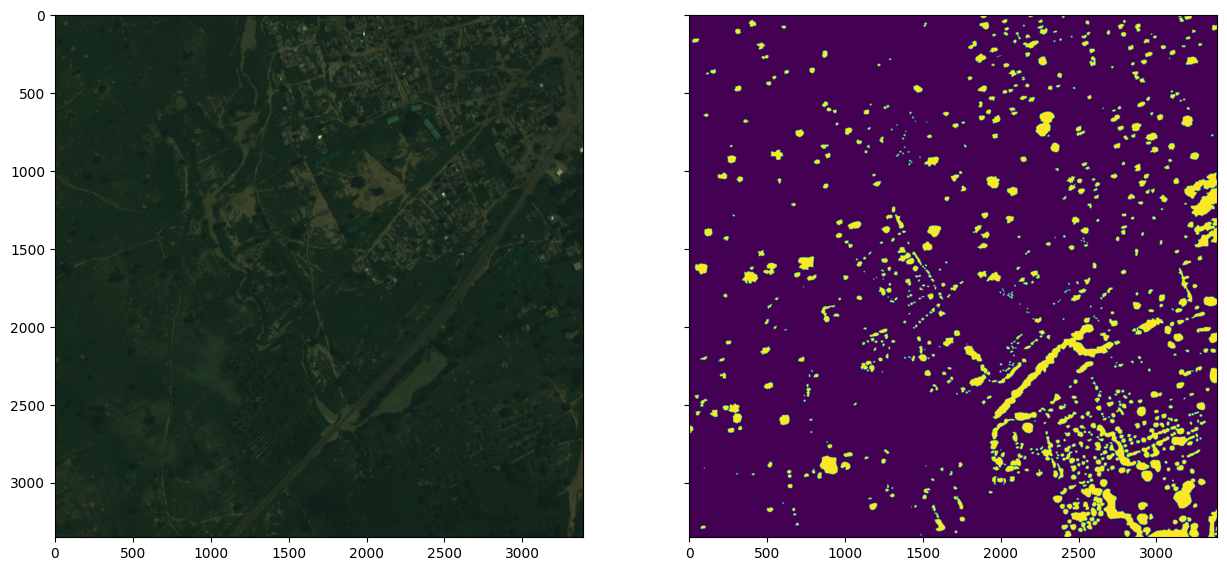

In [52]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(15)
f.set_figwidth(15)
ax1.imshow(image/image.max().max())
ax2.imshow(label/label.max().max())

In [53]:
print(image.shape, type(image), image.max(), image.min())
print(label.shape, type(label), label.max(), label.min())
print(type(geo))

(3349, 3391, 3) <class 'numpy.ndarray'> 0.95166016 0.037109375
(3349, 3391) <class 'numpy.ndarray'> 1 0
<class 'shapely.geometry.multipolygon.MultiPolygon'>


## Dataset

In [54]:
images_test = random.sample(list(df.ImageId.unique()),2)
images_train = np.setdiff1d(df.ImageId.unique(), images_test)

# test_images = random.sample(list(df.ImageId.drop_duplicates()), len(df.ImageId.drop_duplicates())//10)
# train_images = np.setdiff1d(list(df.ImageId.drop_duplicates()), test_images)


images_train
# df.ImageId.unique()

array(['6010_4_2', '6010_4_4', '6040_1_0', '6040_1_3', '6040_2_2',
       '6040_4_4', '6060_2_3', '6070_2_3', '6090_2_0', '6100_1_3',
       '6100_2_2', '6100_2_3', '6110_1_2', '6110_3_1', '6110_4_0',
       '6120_2_0', '6140_1_2', '6140_3_1', '6150_2_3', '6160_2_1',
       '6170_0_4', '6170_2_4', '6170_4_1'], dtype=object)

### divide to test and train

In [55]:
import random
random.seed(2)  

In [56]:
train_sub_image_options = []
test_sub_image_options = []


sub_image_size=(224, 224)
overlap_ratio = 0.5
N_test = 50
min_h, min_w = np.array([[i.shape[0], i.shape[1]] for i in images]).min(axis=0) \
                // (np.array(sub_image_size) * overlap_ratio) * (np.array(sub_image_size) * overlap_ratio)

min_h = int(min_h)
min_w = int(min_w)

print('min image dims:', min_h, min_w)


step_size_h = int(sub_image_size[0] * (1 - overlap_ratio))
step_size_w = int(sub_image_size[1] * (1 - overlap_ratio))

top_coordinates = list(range(0, min_h - sub_image_size[0] + 1, step_size_h))
left_coordinates = list(range(0, min_w - sub_image_size[1] + 1, step_size_w))

for im in range(len(images_train)): 
    all_cors = list(itertools.product(top_coordinates, left_coordinates))
    test_cors = random.sample(list(itertools.product(top_coordinates, left_coordinates)), N_test)
    exclude = []
    for i in test_cors:
        exclude.append((int(min(i[0] + overlap_ratio * sub_image_size[0],  min_h - sub_image_size[0] )),
                        int(min(i[1] + overlap_ratio * sub_image_size[1],  min_w - sub_image_size[0] ))))
        exclude.append((int(max(i[0] - overlap_ratio * sub_image_size[0], 0)),
                        int(max(i[1] - overlap_ratio * sub_image_size[1], 0    ))))
#         print((i[0],i[1]),'   ',#               exclude[-1],'   ',#               exclude[-2],'   ')
    exclude = test_cors + exclude   

    for e in list(set(exclude)):
        all_cors.remove(e)
    
    exclude = [(im,) + ii for ii in  exclude ]
    include = [(im,) + ii for ii in  all_cors ]
    test_cors = [(im,) + ii for ii in  test_cors ]
    
    test_sub_image_options = test_sub_image_options + test_cors
    train_sub_image_options = train_sub_image_options + include

# print(len(include))
# print(len(exclude))
# print(len(test_cors))
print()
print('train images#:     ', len(train_sub_image_options))
print('test images#:      ', len(test_sub_image_options))
print('test/train ratio %:', len(test_sub_image_options)/len(train_sub_image_options) * 100)
print(3/625 * 100)


min image dims: 3248 3248

train images#:      14812
test images#:       1150
test/train ratio %: 7.763975155279502
0.48


In [57]:
import gc
gc.collect()
torch.cuda.empty_cache()

### define DS

In [58]:
device = 'cuda'

data_transform_image = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        transforms.Lambda(lambda x: x.float().to(device)),
    ])

data_transform_label = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.float().to(device) * 255),
        
    ])

# Define your custom dataset class
class RGBChunkedDataset(Dataset):
    def __init__(self, images, labels, sub_image_options, 
                 transform_image=data_transform_image, transform_label=data_transform_label, 
                 sub_image_size=(224, 224)):
        self.images = images
        self.labels = labels
        self.sub_image_size = sub_image_size
        self.transform_image = data_transform_image
        self.transform_label = data_transform_label
        self.top_coordinates = top_coordinates
        self.left_coordinates = left_coordinates
        self.sub_image_options = sub_image_options

    def __len__(self):
        return len(self.sub_image_options)

    def __getitem__(self, idx):
        # Get coordinates for sub-image extraction
        image_id = self.sub_image_options[idx][0]
        top_i = self.sub_image_options[idx][1]  #np.random.choice(self.top_coordinates)
        left_i = self.sub_image_options[idx][2]  #np.random.choice(self.left_coordinates)
#         print(image_id,top_i, left_i)
        rgb_array = self.images[image_id]
        mask = self.labels[image_id]
        
        # Crop sub-images from the original images
        rgb_sub_image = rgb_array[top_i:top_i + self.sub_image_size[0], left_i:left_i + self.sub_image_size[1], :]
        mask_sub_image = mask[top_i:top_i + self.sub_image_size[0], left_i:left_i + self.sub_image_size[1]]
        
        # Apply transformations if specified
        if self.transform_image:
#             print(float(rgb_sub_image.max()))
            rgb_sub_image = self.transform_image(rgb_sub_image)
#             print(float(rgb_sub_image.max()))
        if self.transform_label:
            mask_sub_image = self.transform_label(mask_sub_image)
#             print(mask_sub_image.max())

        return {'image': rgb_sub_image, 'mask': mask_sub_image, 'sub_coordinates':(top_i, left_i)}

batch_size = 64
images_train = images[:]
# images_test = images[0:2]
labels_train = labels[:]
# labels_test = labels[0:2]

# sub_image_options = list(itertools.product(list(range(len(images_train))),top_coordinates, left_coordinates))
# Create an instance of your custom dataset
dataset_train = RGBChunkedDataset(images_train, labels_train, train_sub_image_options, transform_image=data_transform_image, 
                                  transform_label=data_transform_label, sub_image_size=sub_image_size)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)

dataset_test  = RGBChunkedDataset(images_train, labels_train, test_sub_image_options, transform_image=data_transform_image,
                                  transform_label=data_transform_label, sub_image_size=sub_image_size)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

In [59]:
# ii = 0
# for batch in dataloader_test:
#     ii = ii + 1
#     a = batch["image"]
#     b = batch["mask"]
#     s_c = batch["sub_coordinates"]
    
#     if ii>10:
#         break


In [60]:
# img_num = 1
# aa = a[img_num].permute(1, 2, 0).cpu().numpy()
# bb = b[img_num].permute(1, 2, 0).cpu().numpy()
# print(type(aa),s_c[0][img_num], s_c[1][img_num])
# f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
# f.set_figheight(15)
# f.set_figwidth(15)
# ax1.imshow(aa+1)
# ax2.imshow(bb)

In [61]:
def show_one_image_with_pred(inputs, outputs, targets, img_num = 0):
    aa = inputs[img_num].permute(1, 2, 0).cpu().numpy()
    bb = outputs[img_num].permute(1, 2, 0).cpu().detach().numpy()
    cc = targets[img_num].permute(1, 2, 0).cpu().detach().numpy()
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
    f.set_figheight(15)
    f.set_figwidth(15)
    ax1.imshow(aa+1)
    ax2.imshow(bb.round())
    ax3.imshow(cc)

In [62]:


class IoULoss(nn.Module):
    def __init__(self):
        super(IoULoss, self).__init__()

    def forward(self, input, target):
        intersection = torch.logical_and(input, target)
        union = torch.logical_or(input, target)
        iou = torch.sum(intersection) / torch.sum(union)
        loss = 1 - iou
        return loss

# from torchmetrics.classification import Dice
# dice = Dice(average='micro')
   
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        
    def forward(self, inputs, targets):
        smooth = 1.0  # Smoothing factor to prevent division by zero
        intersection = torch.sum(inputs * targets)
        union = torch.sum(inputs) + torch.sum(targets)
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        return 1.0 - dice    


    
class CombinedLoss(nn.Module):
    def __init__(self, gamma=0.85, weight_dice=0.25):
        super(CombinedLoss, self).__init__()
        self.criterion_BCE = nn.BCELoss()
        self.criterion_Dice = DiceLoss()
        self.gamma = gamma
        self.weight_dice = weight_dice
        self.dice_step = dice_step
        
    def get_optimizer_and_scheduler(self, model_parameters):
        optimizer = optim.Adam(model_parameters)
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=self.gamma)
        return optimizer, scheduler
    
    def forward(self, outputs, targets, epoch):

        loss_BCE = self.criterion_BCE(outputs, targets)
        loss_Dice = self.criterion_Dice(outputs, targets)
        loss_comb = loss_Dice * self.weight_dice + \
                    loss_BCE * (1 - self.weight_dice)

        return loss_comb




In [63]:
torch.cuda.empty_cache()

### Original model

In [ ]:
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=1):        
        super().__init__()
        if upsample:
            self.upconv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        else:
            self.upconv = nn.Identity()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) )

    def forward(self, x, skip_connection):
        upsampled = self.upconv(x)
        concatenated = torch.cat([skip_connection, upsampled], dim=1)
        output = self.layers(concatenated)
        return output


In [105]:
class EncoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_c),
            nn.ReLU())
        self.pool = nn.MaxPool2d((2, 2))
        
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p
    
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=1):        
        super().__init__()
        if upsample:
            self.upconv = nn.ConvTranspose2d(in_channels, in_channels, kernel_size=2, stride=2)
        else:
            self.upconv = nn.Identity()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True) )

    def forward(self, x, skip_connection):
        upsampled = self.upconv(x)
        concatenated = torch.cat([skip_connection, upsampled], dim=1)
        output = self.layers(concatenated)
        return output

    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(mid_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),  
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),  
    )
    def forward(self, inputs):
        return self.layers(inputs)
    
    
class FinalLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid() 
    )
    def forward(self, inputs):
        return self.layers(inputs)
    
    
class UNet(nn.Module):
    def __init__(self, num_classes, input_features=3, 
                 layer1_features=32, layer2_features=16, layer3_features=24,
                 layer4_features=40, layer5_features=80):
        super(UNet, self).__init__()
        
        self.num_classes = num_classes
        
        # Layer feature sizes
        self.input_features = input_features
        self.layer1_features = layer1_features
        self.layer2_features = layer2_features
        self.layer3_features = layer3_features
        self.layer4_features = layer4_features
        self.layer5_features = layer5_features
        
        # Encoder layers
        self.encoder1 = EncoderBlock(self.input_features, self.layer1_features)  
        self.encoder2 = EncoderBlock(self.layer1_features, self.layer2_features)
        self.encoder3 = EncoderBlock(self.layer2_features, self.layer3_features)
        self.encoder4 = EncoderBlock(self.layer3_features, self.layer4_features)
        self.encoder5 = EncoderBlock(self.layer4_features, self.layer5_features)
        
        # Bottleneck Layer
        self.bottleneck = DoubleConv(self.layer5_features, self.layer5_features, self.layer5_features,)

        # Decoder layers
        self.decoder1 = DecoderBlock(self.layer5_features, self.layer4_features)
        self.decoder2 = DecoderBlock(self.layer4_features, self.layer3_features)
        self.decoder3 = DecoderBlock(self.layer3_features, self.layer2_features)
        self.decoder4 = DecoderBlock(self.layer2_features, self.layer1_features, upsample=0)
        self.decoder5 = DecoderBlock(self.layer1_features, self.layer1_features)
        
        # Final convolution 
        self.final_conv = FinalLayer(self.layer1_features, self.num_classes)        

    def forward(self, x):
        # Encoder (contracting path)
        output1, p1 = self.encoder1(x)
        output2, _ = self.encoder2(p1)
        output3, p3 = self.encoder3(output2)
        output4, p4 = self.encoder4(p3)
        output5, p5 = self.encoder5(p4)
        
        # Bottleneck Layer
        bn = self.bottleneck(p5)

        up1 = self.decoder1(bn,   output5)
        up2 = self.decoder2(up1 , output4)  
        up3 = self.decoder3(up2 , output3)
        up4 = self.decoder4(up3 , output2)
        up5 = self.decoder5(up4 , output1)
        # Final convolution to produce segmentation mask
        res = self.final_conv(up5)

        return res

device='cuda'
# Instantiate the model
num_classes = 1  # Binary segmentation
pretrained = True
model_orig = UNet(num_classes)
model_orig.to(device)
print()

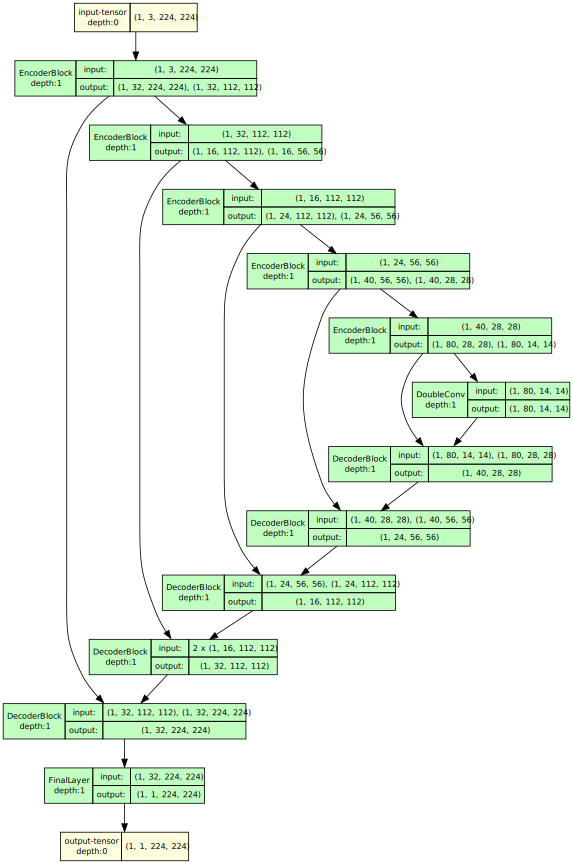

In [106]:
model_graph = draw_graph(model_orig, input_size=(1,3,224,224), expand_nested=True, depth=1)
model_graph.visual_graph

batch_num:  0
    batch loss: 0.8170
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  25
    batch loss: 0.5878
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  50
    batch loss: 0.5575
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  75
    batch loss: 0.4935
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  100
    batch loss: 0.4582
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  125
    batch loss: 0.4254
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  150
    batch loss: 0.4060
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  175
    batch loss: 0.3694
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  200
    batch loss: 0.3610
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  225
    batch loss: 0.3533
    LR ENC:  0.0005     LR_DEC:  0.0005

EPOCH # 0
          TRAIN LOSS BCE : 0.4662
          TEST LOSS BCE : 0.3479
LR ENC:  0.000425 LR_DEC:  0.000425
batch_num:  0
    batch loss: 0.3237
    LR ENC:  0.000425     LR_DEC:  0.000425
batch_num:  25
    b

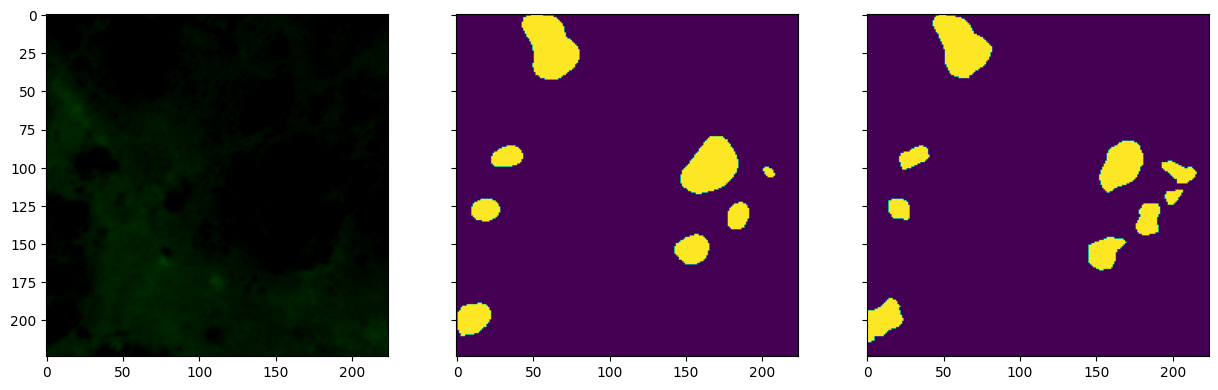

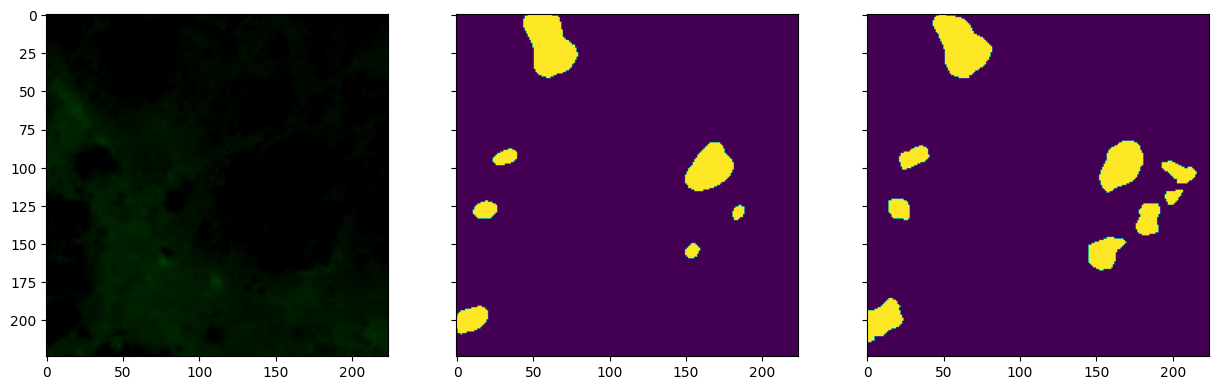

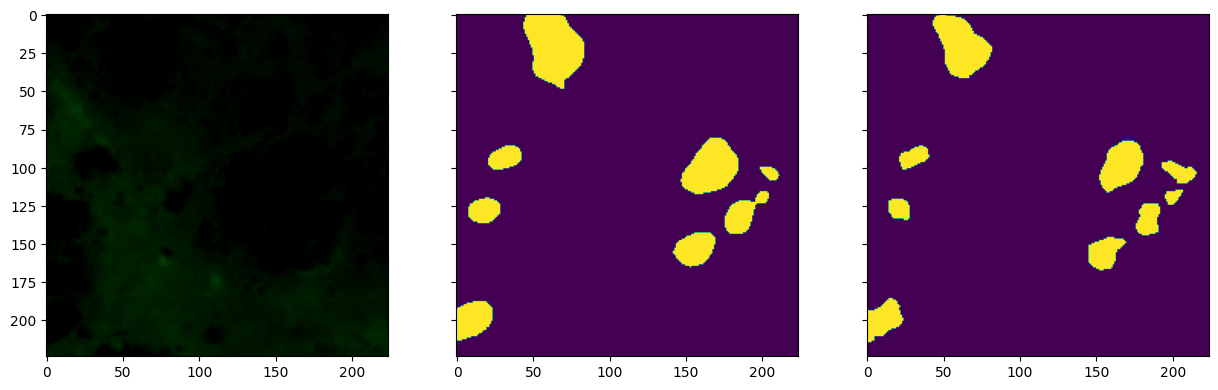

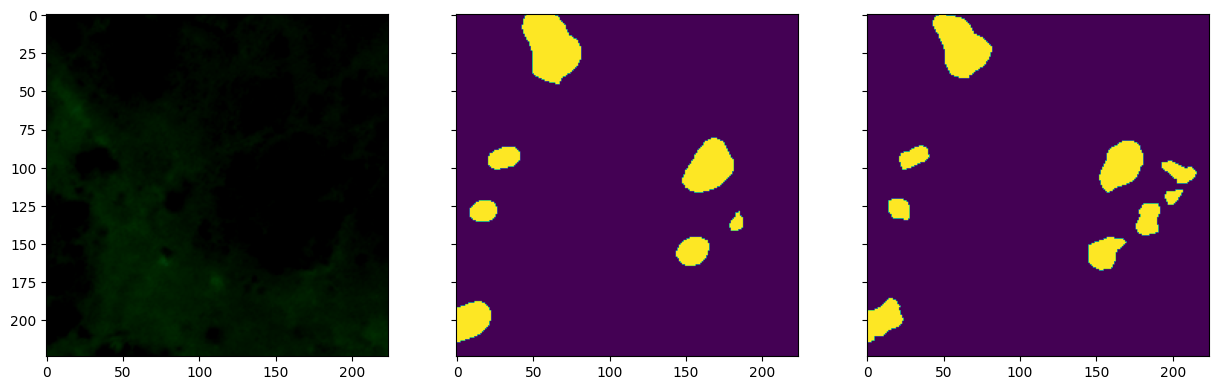

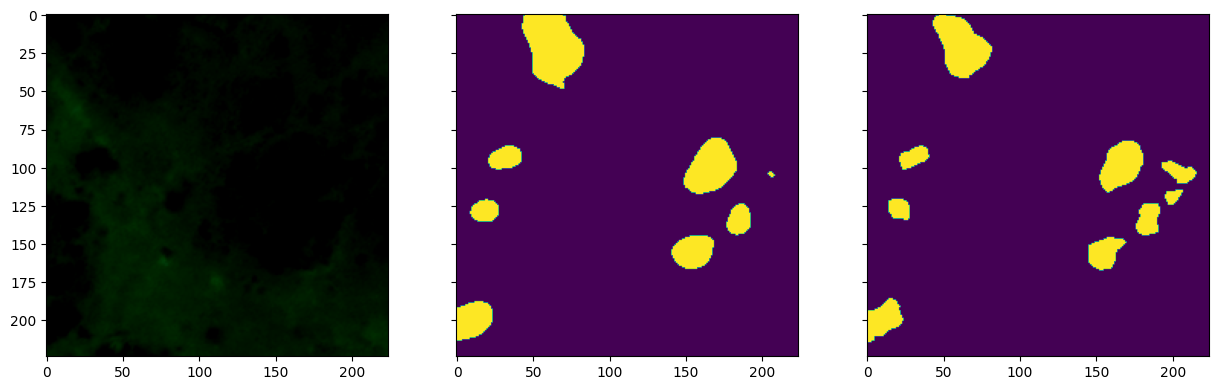

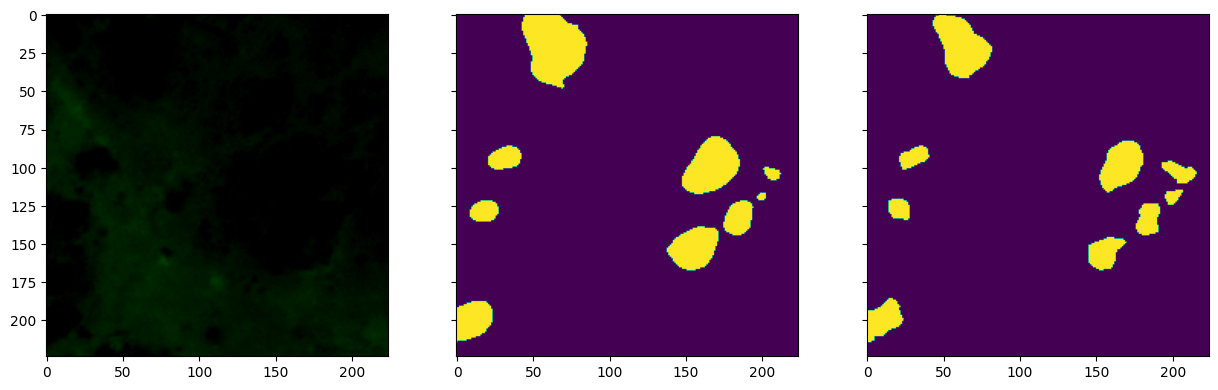

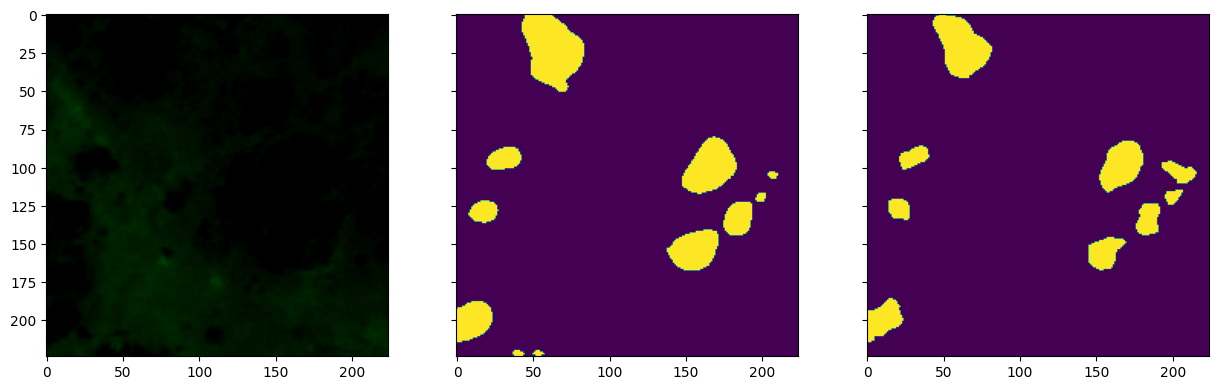

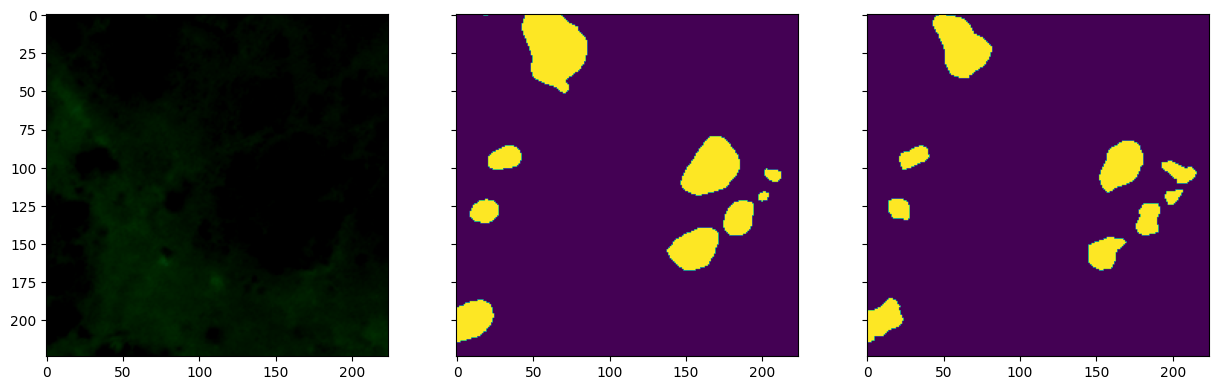

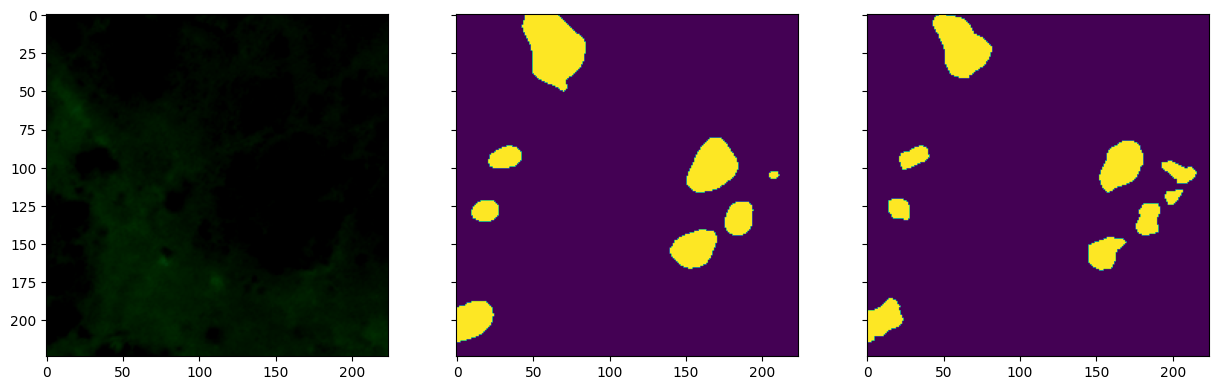

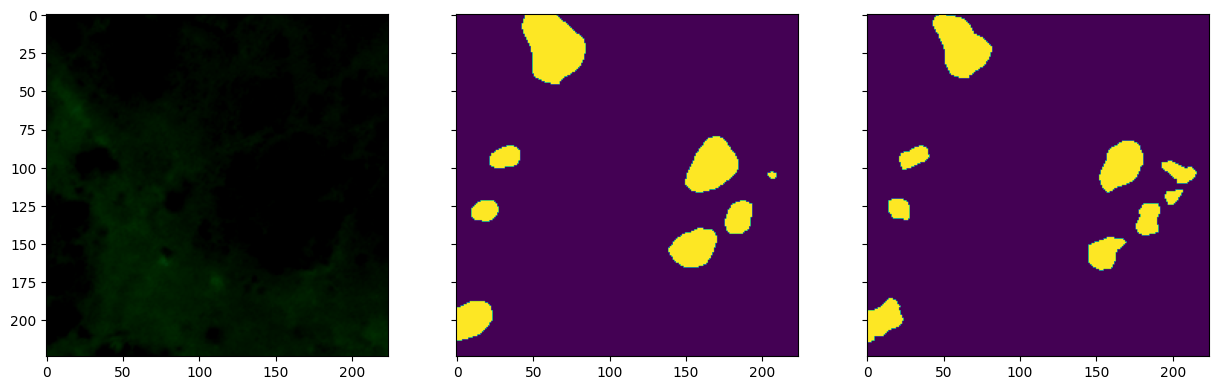

In [107]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define loss function and optimizer
criterion_BCE = nn.BCELoss()
criterion_Dice = DiceLoss()

# define and init epoch params
lr_e = 0.0005
lr_d = 0.0005
model_parameters = [
    {'params': model_orig.encoder1.parameters(), 'lr': lr_e},
    {'params': model_orig.encoder2.parameters(), 'lr': lr_e},
    {'params': model_orig.encoder3.parameters(), 'lr': lr_e},
    {'params': model_orig.encoder4.parameters(), 'lr': lr_e},
    {'params': model_orig.encoder5.parameters(), 'lr': lr_e},
    {'params': model_orig.bottleneck.parameters(), 'lr': lr_d},
    {'params': model_orig.decoder1.parameters(), 'lr': lr_d},
    {'params': model_orig.decoder2.parameters(), 'lr': lr_d},
    {'params': model_orig.decoder3.parameters(), 'lr': lr_d},
    {'params': model_orig.decoder4.parameters(), 'lr': lr_d},
    {'params': model_orig.decoder5.parameters(), 'lr': lr_d}, 
    {'params': model_orig.final_conv.parameters(), 'lr': lr_d}, 
]
combined_loss = CombinedLoss()
optimizer, scheduler = combined_loss.get_optimizer_and_scheduler(model_parameters)
num_epochs = 10


def train_one_epoch(model, dataloader, optimizer, combined_loss, epoch, train_loss_hist_batch, optimizer_hist_batch):
    model.train()
    total_loss = 0
    num_batches = 0
    batch_num = 0
    
    for batch in dataloader:
        inputs, targets = batch['image'], batch['mask']
        outputs = model(inputs)
        loss_comb = combined_loss(outputs, targets, epoch)
    
        optimizer.zero_grad()
        loss_comb.backward()
        optimizer.step()
        
        train_loss_hist_batch.append(loss_comb.item())
        optimizer_hist_batch.append(optimizer.param_groups[0]['lr'])

        if batch_num % 25 == 0:
            print("batch_num: ", batch_num)
            print("    batch loss: %.4f" % float(loss_comb))
            print('    LR ENC: ', optimizer.param_groups[0]['lr'],
                  '    LR_DEC: ', optimizer.param_groups[6]['lr'])
        batch_num += 1 

        total_loss += loss_comb.item()
        num_batches += 1
        
    epoch_loss = total_loss / num_batches    
    return epoch_loss

def calc_validation_loss_one_epoch(model, dataloader, combined_loss):
    model.eval()
    num_batches_test = 0
    total_loss_test = 0
#     total_loss_test_BCE = 0
#     total_loss_test_Dice = 0

    with torch.no_grad():                
        for batch in dataloader:
            num_batches_test += 1
            inputs_test, targets_test = batch['image'], batch['mask']
            outputs_test = model(inputs_test)                    
            loss_test = combined_loss(outputs_test, targets_test, epoch)
            total_loss_test += loss_test.item()

    epoch_loss_test = total_loss_test / num_batches_test 
    
    show_one_image_with_pred(inputs_test, outputs_test, targets_test)
    return epoch_loss_test

# Initialize lists to store results
train_loss_hist = []
train_loss_hist_monitor = []
train_loss_hist_batch = []
val_loss_hist = []
optimizer_hist_batch = []

# Iterate through epochs for training
for epoch in range(num_epochs):
    # Train one epoch
    epoch_loss = train_one_epoch(model_orig, dataloader_train, optimizer, combined_loss, epoch, train_loss_hist_batch, optimizer_hist_batch)
    print()
    print("EPOCH #", epoch)
    print("        ", " TRAIN LOSS BCE : %.4f" % float(epoch_loss))

    # Calculate validation loss for the epoch
    epoch_loss_test = calc_validation_loss_one_epoch(model_orig, dataloader_test, combined_loss)
    model_orig.train()
    print("          TEST LOSS BCE : %.4f" % float(epoch_loss_test))
    
    # Other updates and storage as needed
    scheduler.step()
    train_loss_hist.append(epoch_loss)
    val_loss_hist.append(epoch_loss_test)
    
    print('LR ENC: ', optimizer.param_groups[0]['lr'],
          'LR_DEC: ', optimizer.param_groups[6]['lr'])

    



In [108]:
torch.save(model_orig.state_dict(), '/kaggle/working/models/orig_2')

In [109]:
losses_all = pd.DataFrame([train_loss_hist, val_loss_hist]).T
losses_all.columns = ['TR_loss','VAL_loss']
losses_all = losses_all.reset_index()
px.line(losses_all, x = 'index', y = losses_all.columns[1:])


In [110]:
losses_all = pd.DataFrame([train_loss_hist_batch, [x*1000 for x in optimizer_hist_batch]]).T
losses_all.columns = ['TR_loss', 'LR*1000']
losses_all = losses_all.reset_index()
px.line(losses_all, x = 'index', y = losses_all.columns[1:])

In [112]:
UNET_ORIG_VALS = [train_loss_hist_batch, [x*1000 for x in optimizer_hist_batch]]
UNET_ORIG_VALS_EPOCH = [train_loss_hist, val_loss_hist]

In [113]:
UNET_ORIG_VALS_EPOCH

[[0.4661962979569517,
  0.2923756236017778,
  0.23323849620747156,
  0.20469490220320635,
  0.19108570861662255,
  0.1785427918336515,
  0.17311704659770275,
  0.16966297098531805,
  0.1638320647822372,
  0.16125083952371416],
 [0.3478804760509067,
  0.27233345889382893,
  0.26430051277081174,
  0.2388137107094129,
  0.18577208576930893,
  0.19357485448320708,
  0.18568165765868294,
  0.21172193893127972,
  0.17801628758509955,
  0.14967583864927292]]

### Pretrained transfer learning model

In [119]:
       
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, upsample=1):        
        super().__init__()
        if upsample:
            self.upconv = nn.ConvTranspose2d(in_channels*2, in_channels*2, kernel_size=2, stride=2)
        else:
            self.upconv = nn.Identity()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels * 2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, x, skip_connection):
 
        target_height = x.size(2)
        target_width = x.size(3)
        skip_interp = F.interpolate(skip_connection, size=(target_height, target_width), mode='bilinear', align_corners=False)
        
        concatenated = torch.cat([skip_interp,  x], dim=1)   

        concatenated = self.upconv(concatenated)
            
        output = self.layers(concatenated)
        return output

    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1), 
            nn.BatchNorm2d(mid_channels), 
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),  
            nn.BatchNorm2d(out_channels), 
            nn.ReLU(inplace=True),  
    )
    def forward(self, inputs):
        return self.layers(inputs)
    

class FinalLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid() 
    )
    def forward(self, inputs):
        return self.layers(inputs)  
    
    
class UNet(nn.Module):
    def __init__(self, num_classes, pretrained=True,
                input_features=3, layer1_features=32, layer2_features=16,
                layer3_features=24, layer4_features=40, layer5_features=80):
        super(UNet, self).__init__()
        self.effnet = models.efficientnet_b0(pretrained=pretrained)

        self.num_classes = num_classes

#         # Layer feature sizes
        self.input_features = input_features
        self.layer1_features = layer1_features
        self.layer2_features = layer2_features
        self.layer3_features = layer3_features
        self.layer4_features = layer4_features
        self.layer5_features = layer5_features
        
#         Encoder layers
        self.encoder1 = nn.Sequential(*list(self.effnet.features.children())[0])  #out 32,112*112
        self.encoder2 = nn.Sequential(*list(self.effnet.features.children())[1])  #out 16,112*112
        self.encoder3 = nn.Sequential(*list(self.effnet.features.children())[2])  #out 24,56*56
        self.encoder4 = nn.Sequential(*list(self.effnet.features.children())[3])  #out 40,28*28
        self.encoder5 = nn.Sequential(*list(self.effnet.features.children())[4])  #out 40,28*28
        
        del self.effnet
        
        for param in self.encoder1.parameters():
            param.requires_grad = False
        for param in self.encoder2.parameters():
            param.requires_grad = False

        # Bottleneck Layer
        self.bottleneck = DoubleConv(self.layer5_features, self.layer5_features, self.layer5_features)   
        
        # Decoder layers
        self.decoder1 = DecoderBlock(self.layer5_features, self.layer4_features)
        self.decoder2 = DecoderBlock(self.layer4_features, self.layer3_features)
        self.decoder3 = DecoderBlock(self.layer3_features, self.layer2_features)
        self.decoder4 = DecoderBlock(self.layer2_features, self.layer1_features, upsample=0)
        self.decoder5 = DecoderBlock(self.layer1_features, self.layer1_features)        
        
        # Final layer
        self.final_conv = FinalLayer(self.layer1_features, self.num_classes)
        
        
    def forward(self, x):
        # Encoder (contracting path)
        output1 = self.encoder1(x)
        output2 = self.encoder2(output1)
        output3 = self.encoder3(output2)
        output4 = self.encoder4(output3)
        output5 = self.encoder5(output4)
        
        # Bottleneck Layer
        bn = self.bottleneck(output5)
        up1 = self.decoder1(bn,  output5)
        up2 = self.decoder2(up1, output4)
        up3 = self.decoder3(up2, output3)
        up4 = self.decoder4(up3, output2)
        up5 = self.decoder5(up4, output1) 
        
        # Final convolution to produce segmentation mask
        res = self.final_conv(up5)

        return res


# Instantiate the model
num_classes = 1  # Binary segmentation

In [66]:
# pretrained = True
pretrained = True
model = UNet(num_classes, pretrained)
model.to(device)
print()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.



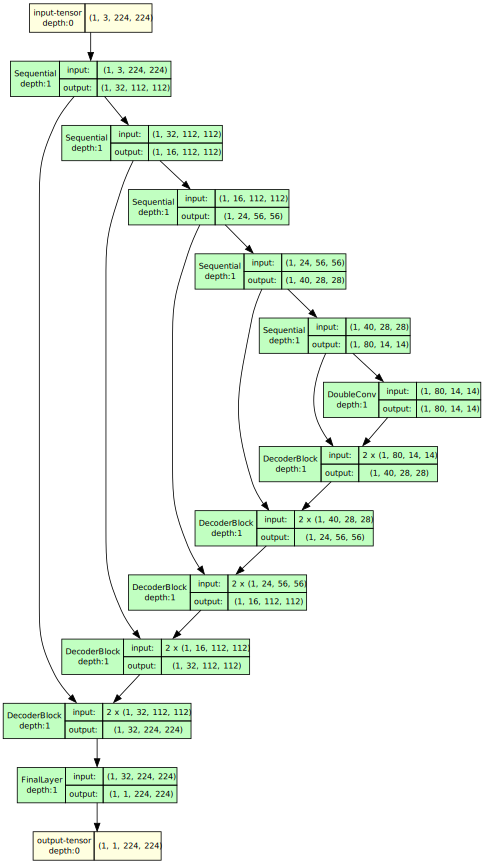

In [67]:
model_graph = draw_graph(model, input_size=(1,3,224,224), expand_nested=True, depth=1)
model_graph.visual_graph

In [70]:
print( sum(p.numel() for p in model_orig.parameters()))
# print( sum(p.numel() for p in model_orig.parameters()))
torch.cuda.empty_cache()

441137


In [68]:
print( sum(p.numel() for p intorchsummary  model.parameters()))
# print( sum(p.numel() for p in model_orig.parameters()))
torch.cuda.empty_cache()

728949


In [72]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Assuming 'model' is your PyTorch model
total_params = count_parameters(model)
print(f"Number of trainable parameters in the model: {total_params}")


Number of trainable parameters in the model: 726573


batch_num:  0
    batch loss: 0.8151
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  25
    batch loss: 0.5951
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  50
    batch loss: 0.4971
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  75
    batch loss: 0.4596
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  100
    batch loss: 0.4404
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  125
    batch loss: 0.3870
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  150
    batch loss: 0.3628
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  175
    batch loss: 0.3358
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  200
    batch loss: 0.3246
    LR ENC:  0.00015     LR_DEC:  0.0005
batch_num:  225
    batch loss: 0.2935
    LR ENC:  0.00015     LR_DEC:  0.0005

EPOCH # 0
          TRAIN LOSS BCE : 0.4279
          TEST LOSS BCE : 0.3065
LR ENC:  0.00012749999999999998 LR_DEC:  0.000425
batch_num:  0
    batch loss: 0.3118
    LR ENC:  0.00012749999999999998     

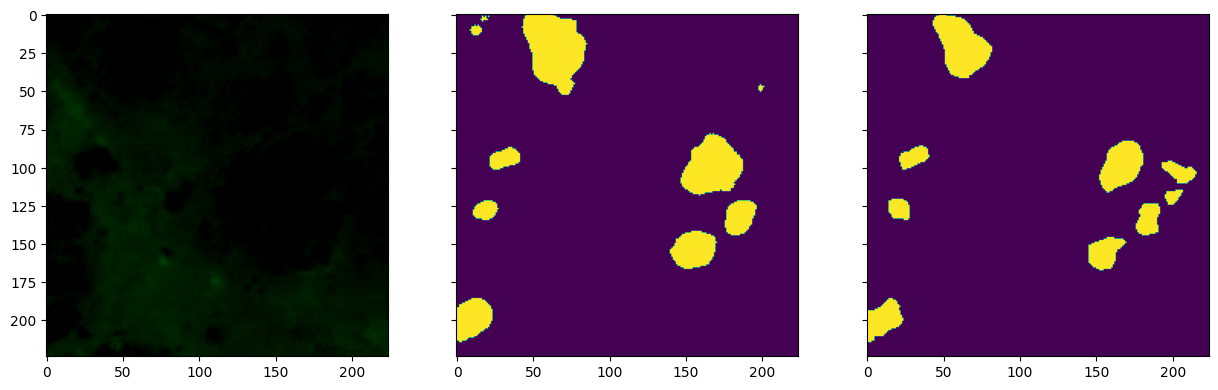

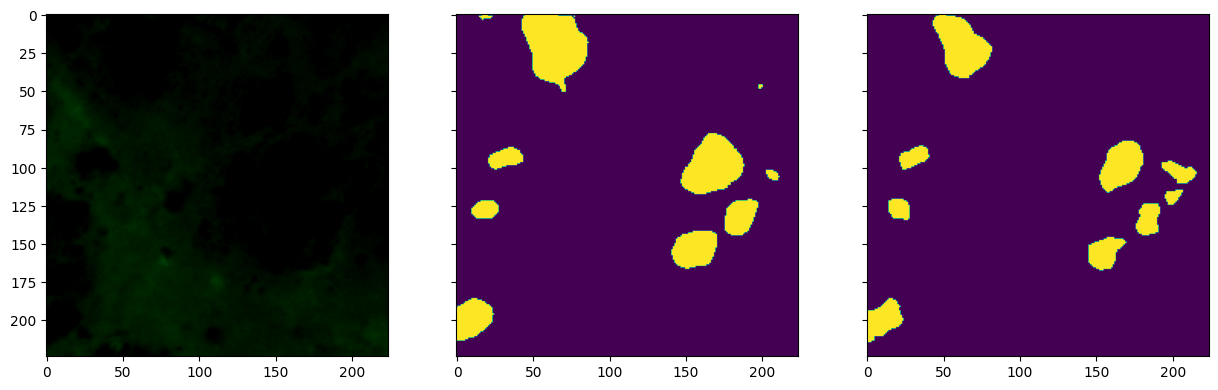

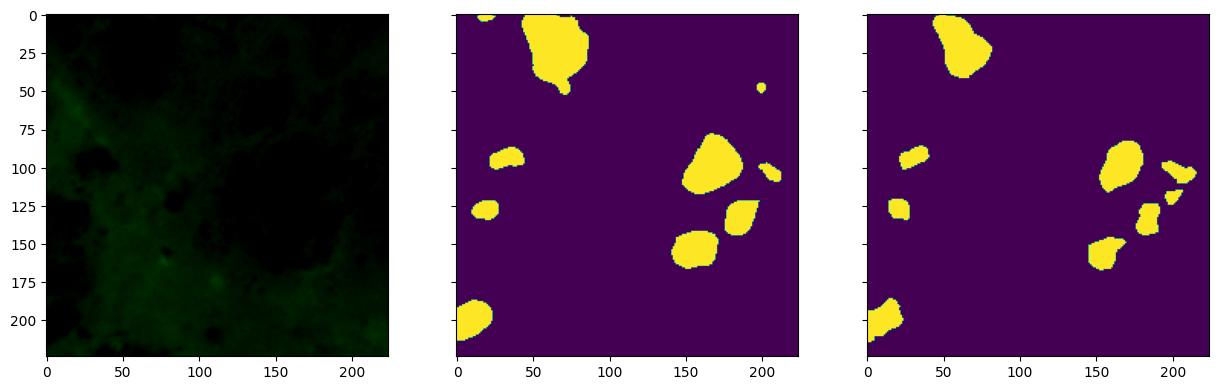

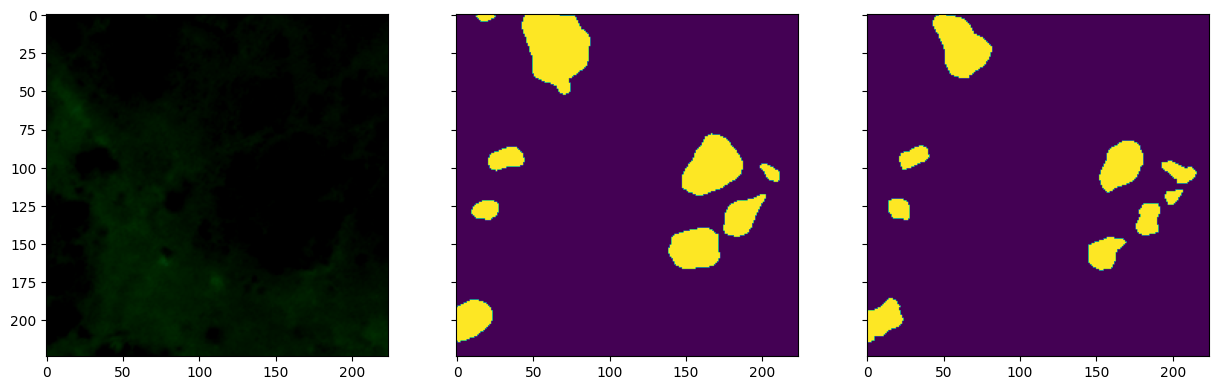

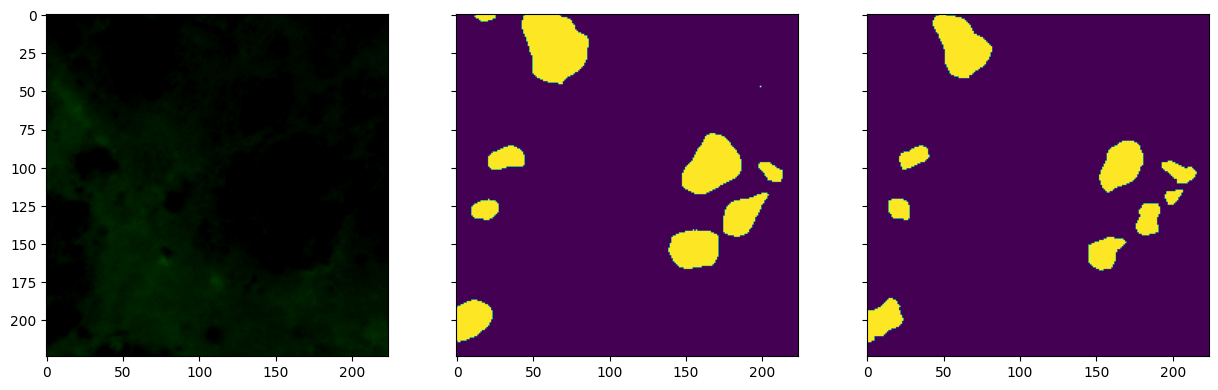

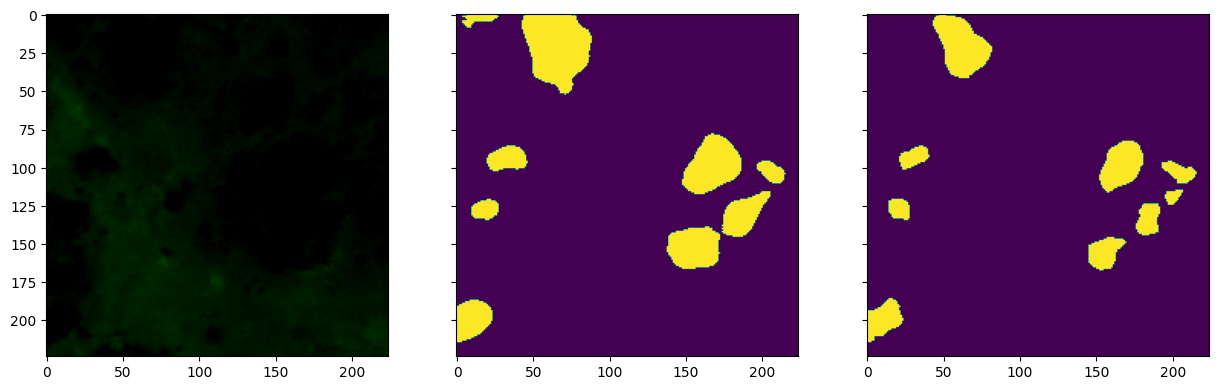

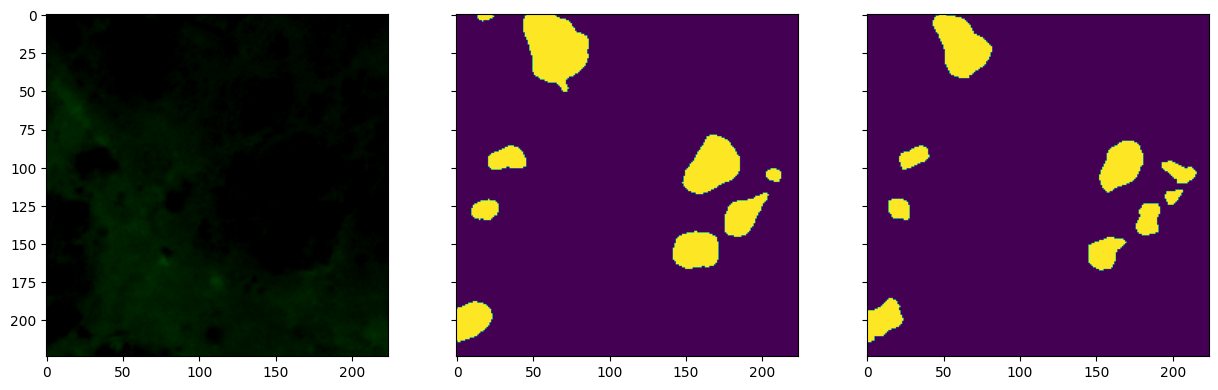

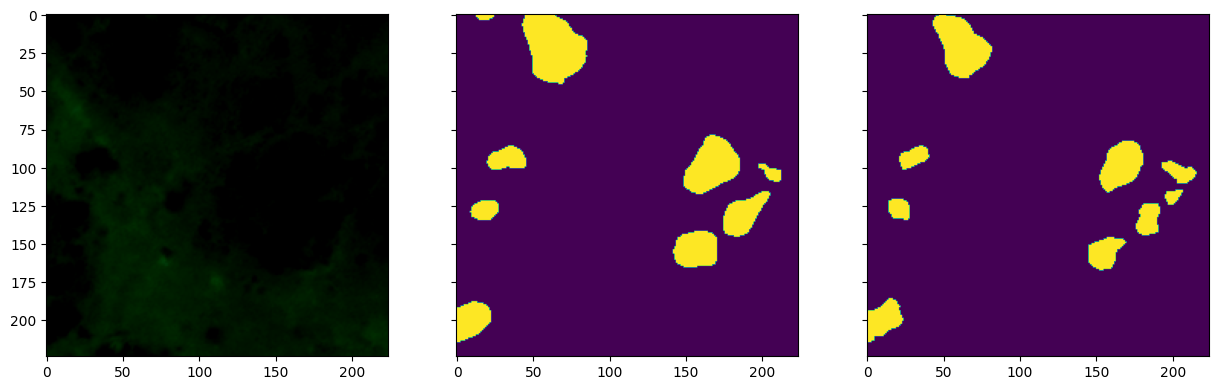

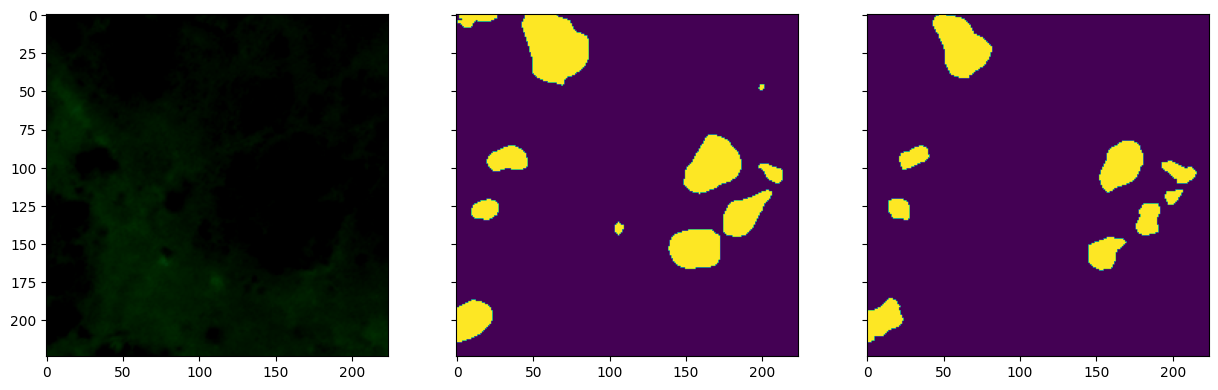

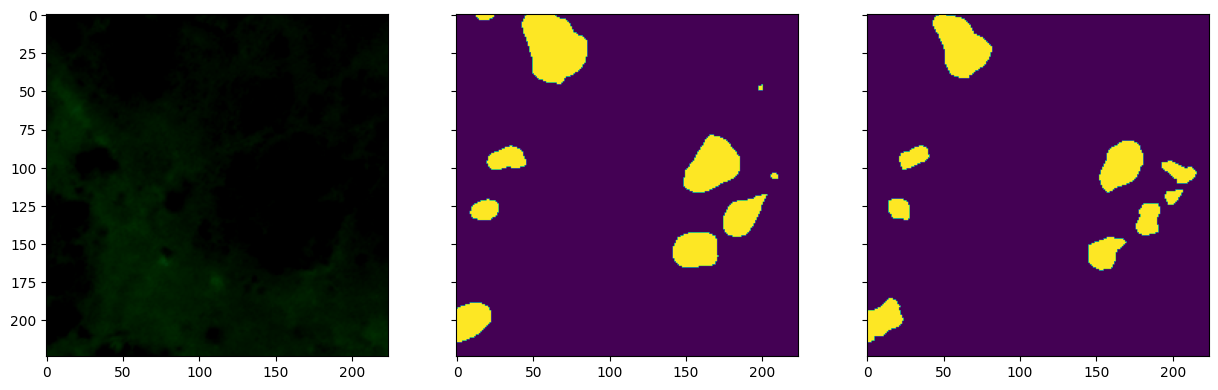

In [73]:
# define and init epoch params
lr_e = 0.00015
lr_d = 0.0005
model_parameters = [
#     {'params': model.encoder1.parameters(), 'lr': lr_e},
#     {'params': model.encoder2.parameters(), 'lr': lr_e},
#     {'params': model.encoder3.parameters(), 'lr': lr_e},
    {'params': model.encoder4.parameters(), 'lr': lr_e},
    {'params': model.encoder5.parameters(), 'lr': lr_e},
    {'params': model.bottleneck.parameters(), 'lr': lr_d},
    {'params': model.decoder1.parameters(), 'lr': lr_d},
    {'params': model.decoder2.parameters(), 'lr': lr_d},
    {'params': model.decoder3.parameters(), 'lr': lr_d},
    {'params': model.decoder4.parameters(), 'lr': lr_d},
    {'params': model.decoder5.parameters(), 'lr': lr_d}, 
    {'params': model.final_conv.parameters(), 'lr': lr_d}, 
]
combined_loss = CombinedLoss()
optimizer, scheduler = combined_loss.get_optimizer_and_scheduler(model_parameters)

num_epochs = 10    
    
# Initialize lists to store results
train_loss_hist = []
train_loss_hist_monitor = []
train_loss_hist_batch = []
val_loss_hist = []
optimizer_hist_batch = []

# Iterate through epochs for training
for epoch in range(num_epochs):
    # Train one epoch
    epoch_loss =  train_one_epoch(model, dataloader_train, optimizer, combined_loss, 
                                  epoch, train_loss_hist_batch, optimizer_hist_batch)
    print()
    print("EPOCH #", epoch)
    print("        ", " TRAIN LOSS BCE : %.4f" % float(epoch_loss))

    # Calculate validation loss for the epoch
    epoch_loss_test = calc_validation_loss_one_epoch(model, dataloader_test, combined_loss)
    model_orig.train()
    print("          TEST LOSS BCE : %.4f" % float(epoch_loss_test))
    
    # Other updates and storage as needed
    scheduler.step()
    train_loss_hist.append(epoch_loss)
    val_loss_hist.append(epoch_loss_test)
    
    print('LR ENC: ', optimizer.param_groups[0]['lr'],
          'LR_DEC: ', optimizer.param_groups[6]['lr'])



In [74]:
torch.save(model.state_dict(), '/kaggle/working/models/transfer_2')

In [341]:
torch.save(model_orig.state_dict(), '/kaggle/working/models/model_orig2')

In [75]:
# import os
# os.mkdir('/kaggle/working/models')

In [340]:
# model_ = UNet(num_classes, True)
# model_.load_state_dict(torch.load('/kaggle/working/models/transfer_2'))
# model_.to('cuda')

# model_empty_ = UNet(num_classes, False)
# model_empty_.load_state_dict(torch.load('/kaggle/working/models/transfer_empty_1'))
# model_empty_.to('cuda')

In [76]:
# del model
# torch.cuda.empty_cache()

In [89]:
losses_all = pd.DataFrame([train_loss_hist, val_loss_hist]).T
losses_all.columns = ['TR_loss', 'VAL_loss']
losses_all = losses_all.reset_index()
px.line(losses_all, x = 'index', y = losses_all.columns[1:])
# losses_all

In [78]:
losses_all = pd.DataFrame([train_loss_hist_batch, [x*1000 for x in optimizer_hist_batch]]).T
losses_all.columns = ['TR_loss', 'LR']
losses_all = losses_all.reset_index()
px.line(losses_all, x = 'index', y = losses_all.columns[1:])

In [79]:
# print([train_loss_hist_monitor, train_loss_hist, val_loss_hist_BCE,val_loss_hist_Dice])

In [91]:
UNET_TR_VALS = [train_loss_hist_batch, [x*1000 for x in optimizer_hist_batch]]
UNET_TR_VALS_EPOCH = [train_loss_hist ,val_loss_hist]

In [92]:
# sys.getsizeof(model)
UNET_TR_VALS_EPOCH

[[0.4279016790718868,
  0.2425219665185131,
  0.18822912287352414,
  0.16612340291512423,
  0.1540725980724754,
  0.1465107319105802,
  0.1384849174526231,
  0.13515296671539545,
  0.13140378773597808,
  0.12806308108927875],
 [0.3064664718177583,
  0.2038470067911678,
  0.17255166545510292,
  0.15956436014837688,
  0.1479397536151939,
  0.15029352406660715,
  0.1384533867239952,
  0.13436236191127035,
  0.13451341539621353,
  0.1307525543702973]]

In [93]:
def get_model_memory_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    total_size = total_params * 4  # Assuming 4 bytes for each parameter (32-bit floating point)
    total_size += sum(p.storage().size() for p in model.parameters() if p.requires_grad)
    return total_size / 1024 / 1024  # Convert to megabytes (MB)

In [95]:
# get_model_memory_size(model)

#### visualize result

In [241]:
def show_pred(inputs, inputs_tr, outputs, targets):
#     inputs = inputs.cpu().detach().numpy()
#     inputs_tr = inputs_tr.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    f, ax = plt.subplots(2, 2)
    np_rgb_masked = inputs.copy()
    np_rgb_masked[:,:,1] = np_rgb_masked[:,:,1] + targets * 0.25
    np_rgb_masked[:,:,2] = np_rgb_masked[:,:,2] + targets * 0.25
    np_rgb_masked[:,:,0] = np_rgb_masked[:,:,0] + outputs * 0.25
    
    np_rgb_tr_masked = inputs_tr.copy()
    np_rgb_tr_masked[:,:,1] = np_rgb_tr_masked[:,:,1] + targets * 0.25
    np_rgb_tr_masked[:,:,2] = np_rgb_tr_masked[:,:,2] + targets * 0.25
    np_rgb_tr_masked[:,:,0] = np_rgb_tr_masked[:,:,0] + outputs * 0.25
    
    empty = np.zeros(np_rgb_tr_masked.shape)
    empty[:,:,1] = empty[:,:,1] + targets * 0.25
    empty[:,:,2] = empty[:,:,2] + targets * 0.25
    empty[:,:,0] = empty[:,:,0] + outputs * 0.25
    
    f.set_figheight(25)
    f.set_figwidth(25)
    ax[0,0].imshow(inputs_tr)
    ax[0,0].set_title('Input Img')
    
    ax[0,1].imshow(np_rgb_masked)
    ax[0,1].set_title('Input Img + Mask (R=Pr, Cy=T)')
    
    ax[1,0].imshow(np_rgb_tr_masked)
    ax[1,0].set_title('Norm Input Img + Mask (R=Pr, Cy=T)')
    
    ax[1,1].imshow(empty)
    ax[1,1].set_title('Preds vs True Labels (R=Pr, Cy=T)')
    
#     ax4.imshow(np.transpose(outputs, (1, 2, 0)))
#     ax4.set_title('Preds')
    
#     ax5.imshow(np.transpose(targets, (1, 2, 0)))
#     ax5.set_title('Targets')
    
    plt.show()

In [242]:
im_pick = test_sub_image_options[971]
# im_pick 4 254 255 260 361 998 997 996 981

In [325]:
data_transform_image_show = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.51, 0.57, 0.5], std=[0.2, 0.2, 0.2]),
        transforms.Lambda(lambda x: x.float().to(device)),
    ])
image_id = im_pick[0]
top_i = im_pick[1]  #np.random.choice(self.top_coordinates)
left_i = im_pick[2]  #np.random.choice(self.left_coordinates)
rgb_array = images_train[image_id]
mask = labels_train[image_id]
# Crop sub-images from the original images
rgb_sub_image = rgb_array[top_i:top_i + sub_image_size[0], left_i:left_i + sub_image_size[1], :]
mask_sub_image = mask[top_i:top_i + sub_image_size[0], left_i:left_i + sub_image_size[1]]
rgb_sub_image_tr = data_transform_image_show(rgb_sub_image)
mask_sub_image_tr =  data_transform_label(mask_sub_image)

In [351]:
pred_mask = (model_empty_(rgb_sub_image_tr.unsqueeze(0))>0.5).float()[0]
# pred_mask = (model(rgb_sub_image_tr.unsqueeze(0))>0.5).float()[0]
pred_mask.shape

torch.Size([1, 224, 224])

In [352]:
np_rgb = rgb_sub_image_tr.cpu().detach().numpy()
np_rgb = np.transpose(np_rgb - np_rgb.min(), (1,2,0))
# np_rgb_masked = np_rgb.copy() - 0.5
np_rgb_masked = rgb_sub_image.copy()

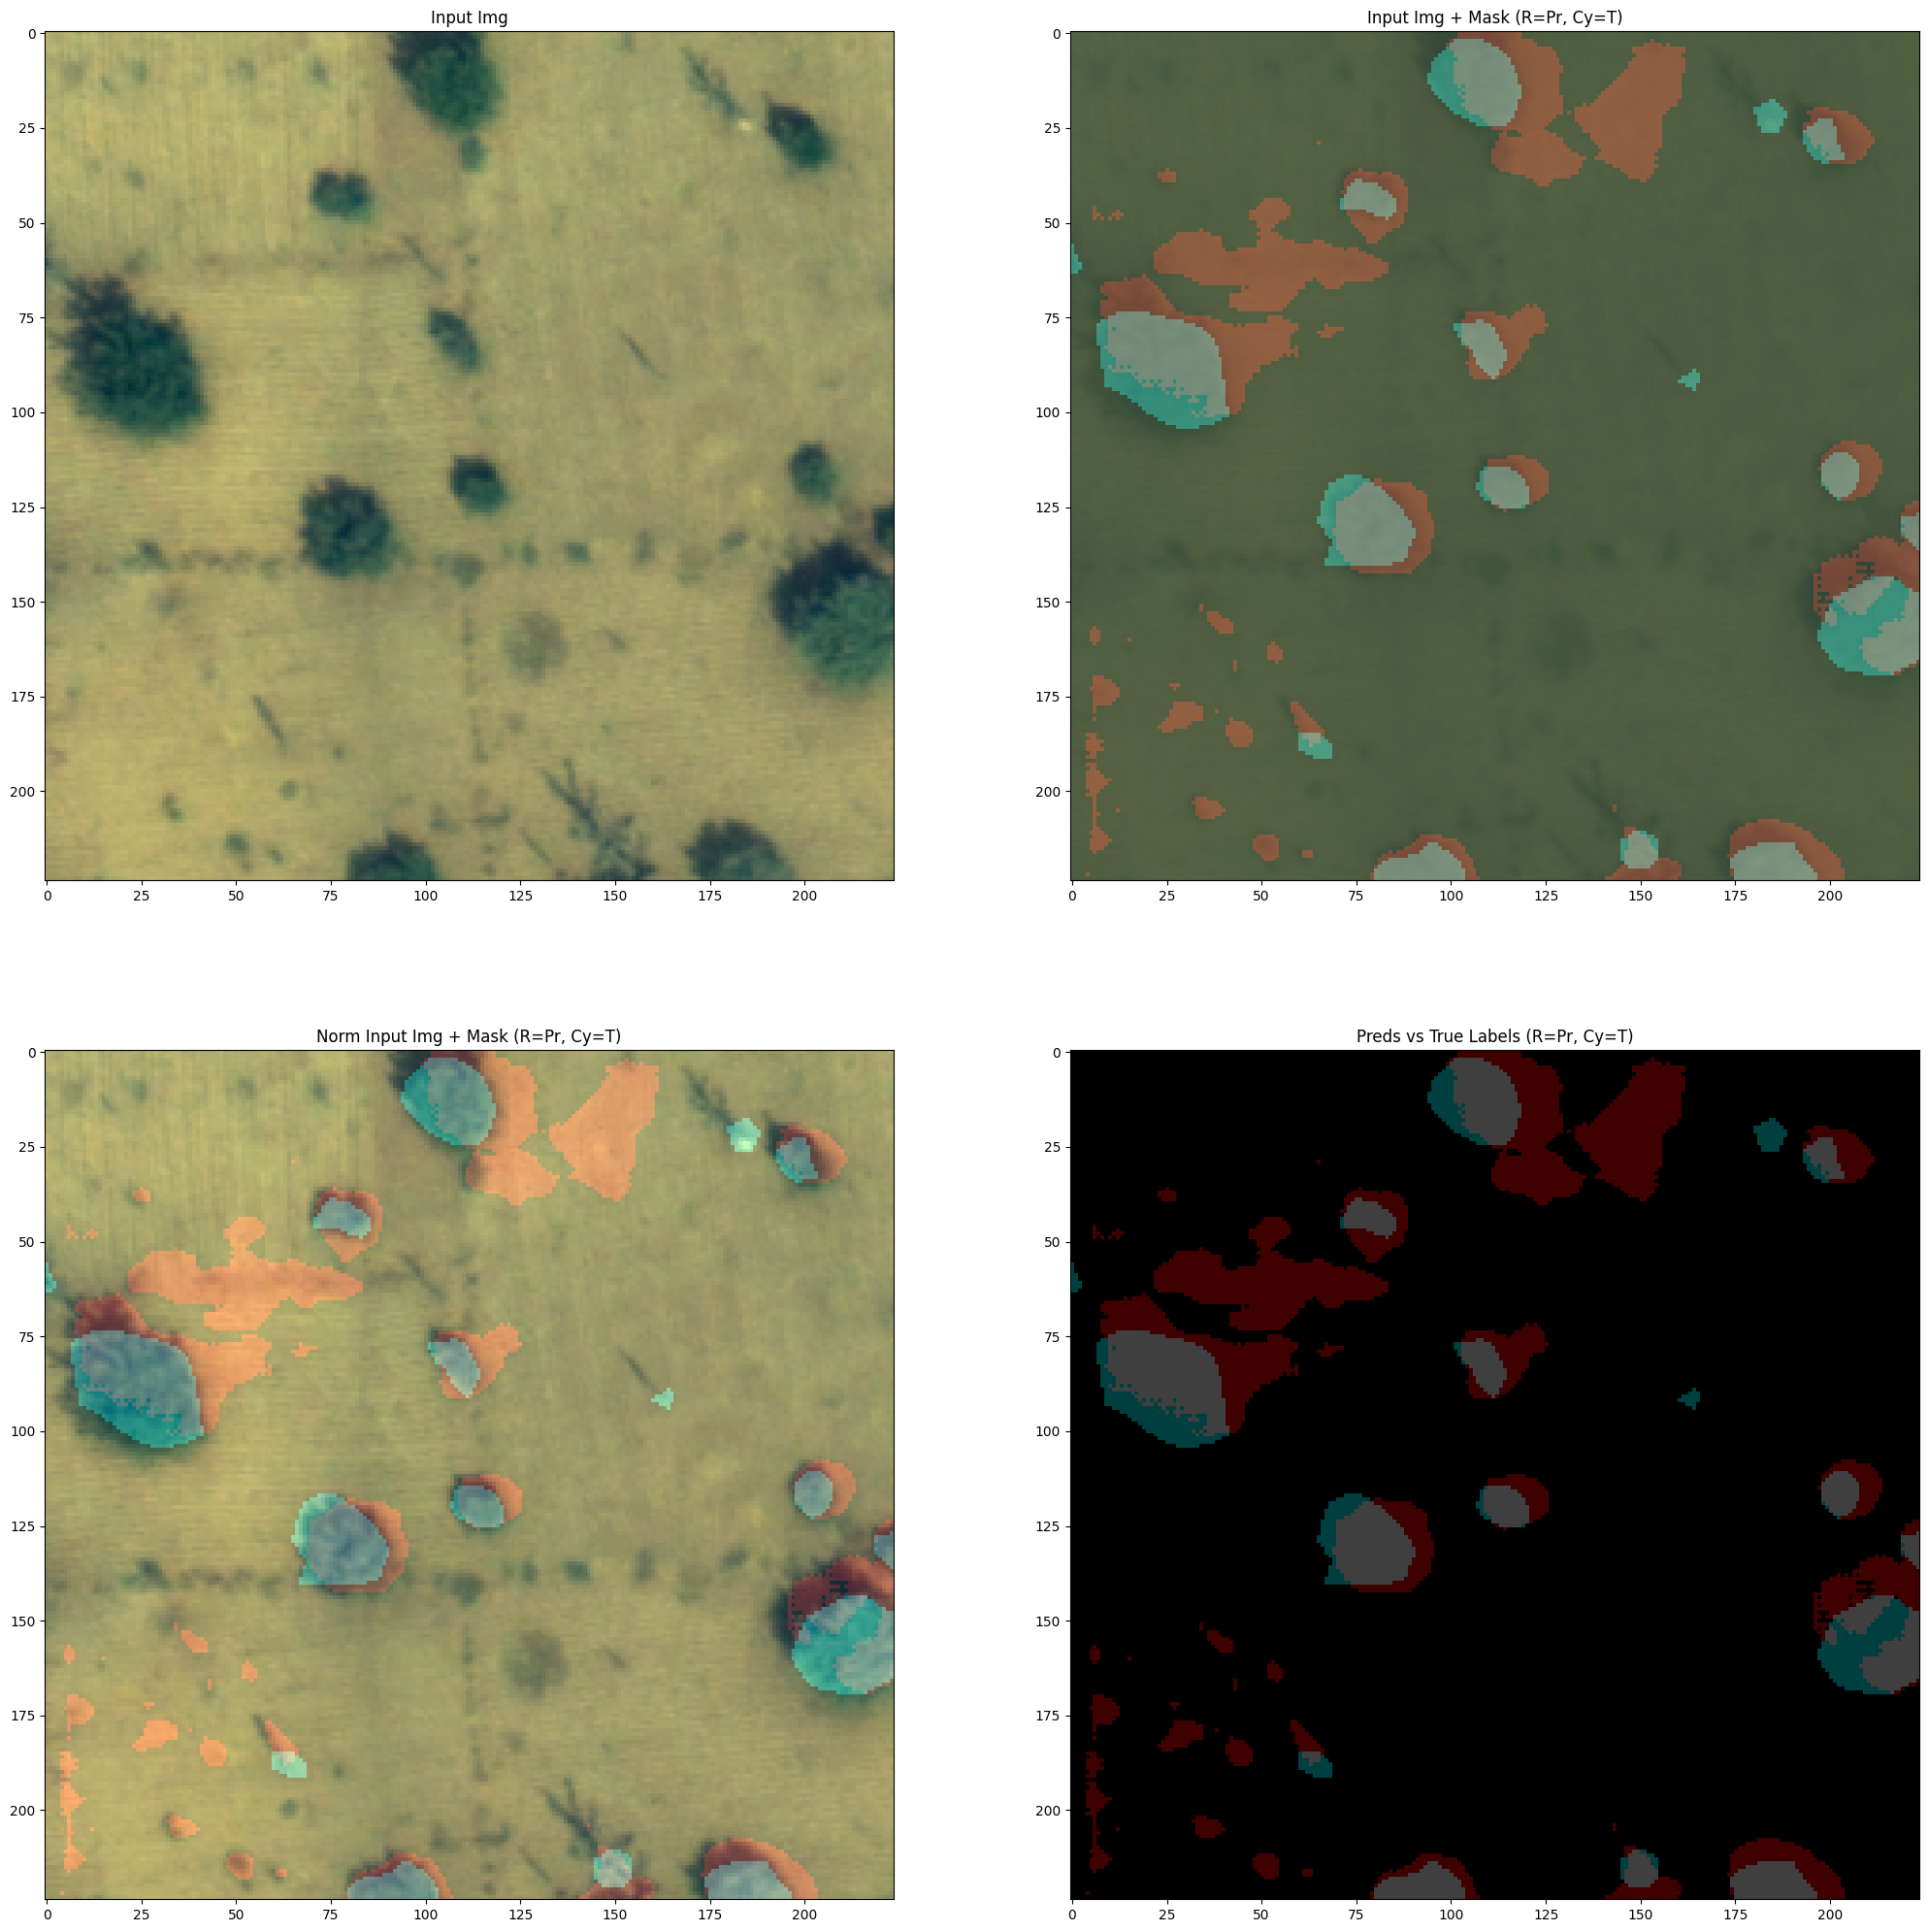

In [353]:
show_pred(rgb_sub_image, np_rgb, pred_mask, mask_sub_image_tr)

In [212]:
# plt.imshow(rgb_sub_image)

In [ ]:
# plt.imshow(mask_sub_image)

In [ ]:
pip install torchsummary


In [ ]:
from torchsummary import summary


In [ ]:
# Assuming `model1` and `model2` are your PyTorch models
summary(model_orig, input_size=(3, 224, 224))

In [ ]:
summary(model, input_size=(3, 224, 224))

In [ ]:
# TRANSFER
# Total params: 1,037,609
# Trainable params: 1,037,609
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.57
# Forward/backward pass size (MB): 427.76
# Params size (MB): 3.96
# Estimated Total Size (MB): 432.29
    
    
# ORIGINAL    
# Total params: 441,137
# Trainable params: 441,137
# Non-trainable params: 0
# ----------------------------------------------------------------
# Input size (MB): 0.57
# Forward/backward pass size (MB): 5204232.58
# Params size (MB): 1.68
# Estimated Total Size (MB): 5204234.84

### Non-pretrained transfer learning model

In [354]:
pretrained = False
model_empty = UNet(num_classes, pretrained)
model_empty.to('cuda')
print()

In [ ]:
# define and init epoch params
lr_e = 0.0005
lr_d = 0.0005
model_parameters =[
    {'params': model_empty.encoder1.parameters(), 'lr': lr_e},
    {'params': model_empty.encoder2.parameters(), 'lr': lr_e},
    {'params': model_empty.encoder3.parameters(), 'lr': lr_e},
    {'params': model_empty.encoder4.parameters(), 'lr': lr_e},
    {'params': model_empty.encoder5.parameters(), 'lr': lr_e},
    {'params': model_empty.bottleneck.parameters(), 'lr': lr_d},
    {'params': model_empty.decoder1.parameters(), 'lr': lr_d},
    {'params': model_empty.decoder2.parameters(), 'lr': lr_d},
    {'params': model_empty.decoder3.parameters(), 'lr': lr_d},
    {'params': model_empty.decoder4.parameters(), 'lr': lr_d},
    {'params': model_empty.decoder5.parameters(), 'lr': lr_d},    
    {'params': model_empty.final_conv.parameters(), 'lr': lr_d},
    
]

combined_loss = CombinedLoss()
optimizer, scheduler = combined_loss.get_optimizer_and_scheduler(model_parameters)

num_epochs = 10    
    
# Initialize lists to store results
train_loss_hist = []
train_loss_hist_monitor = []
train_loss_hist_batch = []
val_loss_hist = []
optimizer_hist_batch = []

# Iterate through epochs for training
for epoch in range(num_epochs):
    # Train one epoch
    epoch_loss =  train_one_epoch(model_empty, dataloader_train, optimizer, combined_loss, epoch, train_loss_hist_batch, optimizer_hist_batch)
    print()
    print("EPOCH #", epoch)
    print("        ", " TRAIN LOSS BCE : %.4f" % float(epoch_loss))

    # Calculate validation loss for the epoch
    epoch_loss_test = calc_validation_loss_one_epoch(model_empty, dataloader_test, combined_loss)
    model_orig.train()
    print("          TEST LOSS BCE : %.4f" % float(epoch_loss_test))
    
    # Other updates and storage as needed
    scheduler.step()
    train_loss_hist.append(epoch_loss)
    val_loss_hist.append(epoch_loss_test)
    
    print('LR ENC: ', optimizer.param_groups[0]['lr'],
          'LR_DEC: ', optimizer.param_groups[6]['lr'])


batch_num:  0
    batch loss: 0.7211
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  25
    batch loss: 0.5594
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  50
    batch loss: 0.4900
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  75
    batch loss: 0.4316
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  100
    batch loss: 0.4326
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  125
    batch loss: 0.4201
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  150
    batch loss: 0.3372
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  175
    batch loss: 0.3244
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  200
    batch loss: 0.3392
    LR ENC:  0.0005     LR_DEC:  0.0005
batch_num:  225
    batch loss: 0.3011
    LR ENC:  0.0005     LR_DEC:  0.0005

EPOCH # 0
          TRAIN LOSS BCE : 0.4188
          TEST LOSS BCE : 0.2973
LR ENC:  0.000425 LR_DEC:  0.000425
batch_num:  0
    batch loss: 0.2954
    LR ENC:  0.000425     LR_DEC:  0.000425
batch_num:  25
    b

In [ ]:
torch.save(model_empty.state_dict(), '/kaggle/working/models/notrain_3')

In [123]:
losses_all = pd.DataFrame([train_loss_hist, val_loss_hist]).T
losses_all.columns = ['TR_loss', 'VAL_loss']
losses_all = losses_all.reset_index()
px.line(losses_all, x = 'index', y = losses_all.columns[1:])
# losses_all

In [124]:
losses_all = pd.DataFrame([train_loss_hist_batch, [x*1000 for x in optimizer_hist_batch]]).T
losses_all.columns = ['TR_loss', 'LR']
losses_all = losses_all.reset_index()
px.line(losses_all, x = 'index', y = losses_all.columns[1:])

In [125]:
# UNET_TR_VALS_no_grad = [train_loss_hist_bce_batch, train_loss_hist_dice_batch, [x*1000 for x in optimizer_hist_batch]]
# UNET_TR_VALS_EPOCH_no_grad = [train_loss_hist, train_loss_hist_monitor, val_loss_hist_BCE,val_loss_hist_Dice]

In [126]:
UNET_TR_VALS_no_pretr = [train_loss_hist_batch, [x*1000 for x in optimizer_hist_batch]]
UNET_TR_VALS_EPOCH_no_pretr = [train_loss_hist, val_loss_hist]

In [127]:
torch.save(model_empty.state_dict(), '/kaggle/working/models/transfer_empty_1')

In [128]:
# all_res.append(train_loss_hist_dice_batch)
all_res = UNET_TR_VALS.copy()
all_res = all_res + UNET_ORIG_VALS
# all_res = all_res + UNET_TR_VALS_no_grad
all_res = all_res + UNET_TR_VALS_no_pretr

In [129]:
losses_all = pd.DataFrame(all_res).T
losses_all.columns = ['TR_BCE', 'LR*1000',
                      'TR_BCE_orig',  'LR*1000_',
#                       'TR_BCE_no_grad', 'TR_Dice_no_grad', 'LR*1000__',
                     'TR_BCE_no_pretr',  'LR*1000___',]
losses_all = losses_all.reset_index()
px.line(losses_all, x = losses_all.columns[0], y = losses_all.columns[1:])

In [137]:
# UNET_ORIG_VALS_EPOCH


In [130]:
all_res_ep = UNET_TR_VALS_EPOCH.copy()
all_res_ep = all_res_ep + UNET_ORIG_VALS_EPOCH
# all_res_ep = all_res_ep + UNET_TR_VALS_EPOCH_no_grad
all_res_ep = all_res_ep + UNET_TR_VALS_EPOCH_no_pretr
# 

In [138]:
all_res_ep_df = pd.DataFrame(all_res_ep).T
all_res_ep_df.columns = ['Transfer_train',  'Transfer_validation', 
                         'Orig_train',  'Orig_validation', 
#                         'NOGRAD_dice', 'NOGRAD_BCE','NOGRAD_VAL_bce', 'NOGRAD_val_dice',
                        'Transfer_empty_train', 'Transfer_empty_validation',]
all_res_ep_df = all_res_ep_df.reset_index()

px.line(all_res_ep_df, x = all_res_ep_df.columns[0], y = all_res_ep_df.columns[1:])

In [132]:
print(all_res_ep_df.values)

[[0.         0.42790168 0.30646647 0.4661963  0.34788048 0.47602706
  0.35240332]
 [1.         0.24252197 0.20384701 0.29237562 0.27233346 0.29370918
  0.24356705]
 [2.         0.18822912 0.17255167 0.2332385  0.26430051 0.23688039
  0.21615949]
 [3.         0.1661234  0.15956436 0.2046949  0.23881371 0.21538658
  0.20826574]
 [4.         0.1540726  0.14793975 0.19108571 0.18577209 0.20056378
  0.17815535]
 [5.         0.14651073 0.15029352 0.17854279 0.19357485 0.19041161
  0.17939209]
 [6.         0.13848492 0.13845339 0.17311705 0.18568166 0.18420044
  0.17390486]
 [7.         0.13515297 0.13436236 0.16966297 0.21172194 0.17942536
  0.16825796]
 [8.         0.13140379 0.13451342 0.16383206 0.17801629 0.17577464
  0.17046478]
 [9.         0.12806308 0.13075255 0.16125084 0.14967584 0.16974899
  0.16087935]]


In [ ]:
# all_res = UNET_TR_VALS.copy()
# all_res = all_res + UNET_ORIG_VALS
# # all_res = all_res + UNET_TR_VALS_no_grad

In [ ]:
import os
os.mkdir('/kaggle/working/data')

In [ ]:
np.save('/kaggle/working/all_res.npy', np.array(all_res_ep_df.values), )

In [ ]:
# print(all_res_ep_df.values)

In [ ]:
# print(list([list(x) for x in losses_all.values]))

In [ ]:
# [[0.        , 0.58888934, 0.27764431, 0.16288561, 0.45195436,
#         0.64388887, 0.29255155, 0.40038208, 0.83673097, 0.64993755,
#         0.2832905 , 0.60367006, 0.68684608],
#        [1.        , 0.38903453, 0.13436748, 0.11272507, 0.35889587,
#         0.42892319, 0.17444982, 0.24905851, 0.61965505, 0.46618532,
#         0.16380679, 0.25481486, 0.71695209],
#        [2.        , 0.33068495, 0.11400367, 0.10641957, 0.3467041 ,
#         0.36785704, 0.16009693, 0.24528941, 0.43541212, 0.41327124,
#         0.14396536, 0.15458548, 0.45317686],
#        [3.        , 0.30668408, 0.10604657, 0.1070045 , 0.2960181 ,
#         0.33697497, 0.1567839 , 0.44788293, 0.72514155, 0.38078128,
#         0.13308544, 0.20346418, 0.47733067],
#        [4.        , 0.28674718, 0.09937649, 0.09644362, 0.28046119,
#         0.31385782, 0.15623861, 0.2517146 , 0.38867749, 0.36317192,
#         0.12718483, 0.1980656 , 0.51422551],
#        [5.        , 0.27546278, 0.09526805, 0.09312145, 0.27983167,
#         0.29542394, 0.1550443 , 0.22636988, 0.37560082, 0.3470358 ,
#         0.12139877, 0.12940267, 0.3670007 ],
#        [6.        , 0.26559482, 0.09165213, 0.09186211, 0.26098362,
#         0.28092989, 0.15766006, 0.26756758, 0.34156691, 0.34014927,
#         0.1191511 , 0.1632618 , 0.42191637],
#        [7.        , 0.25474804, 0.08800668, 0.08999369, 0.25710846,
#         0.26928573, 0.16215956, 0.16506599, 0.27215889, 0.33089329,
#         0.11585203, 0.18279338, 0.37128844],
#        [8.        , 0.24904935, 0.08596478, 0.08973081, 0.24679389,
#         0.25798991, 0.16705552, 0.36828233, 0.34392263, 0.31972326,
#         0.11188933, 0.11290912, 0.31586746],
#        [9.        , 0.24180772, 0.08346306, 0.08529324, 0.25262654,
#         0.24776576, 0.17371754, 0.16512221, 0.25466693, 0.31148518,
#         0.10915294, 0.10818075, 0.31550245]]

'EFFNET-NOT_PRETRAINED'

In [139]:
losses_all_ = losses_all.copy()
epoch_ = UNET_ORIG_VALS_EPOCH + UNET_TR_VALS_EPOCH

In [ ]:
# # Generate train and val samples:
# test_samples = random.sample(range(len(img)), len(img)//20)
# train_samples = np.setdiff1d(range(len(img)), test_samples)

# # Load the data
# train_data  = FK_dataset_train(img[train_samples],
#                                y_train[train_samples],
#                                transform_image=transform_image_train,
#                                transform_combined=combined_transform)

# val_data   = FK_dataset_test(img[test_samples],
#                              y_train[test_samples],
#                              transform=transform_image_test)
# # Define batch size
# batch_size =  16

# # Define dataloaders:
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

In [ ]:

torch.cuda.empty_cache() 

# Initialize your PyTorch model and tensors
# For example:
# tensor1 = torch.randn(1000, 1000).to('cuda')
# tensor2 = torch.randn(500, 500).to('cuda')

# List all the GPU tensors and their memory usage
gpu_tensors = {}
for obj in dir():
    if torch.is_tensor(eval(obj)) and eval(obj).device.type == 'cuda':
        allocated_memory = torch.cuda.memory_allocated(eval(obj).device)
        reserved_memory = torch.cuda.memory_reserved(eval(obj).device)
        gpu_tensors[obj] = {
            'allocated_memory (bytes)': allocated_memory,
            'reserved_memory (bytes)': reserved_memory
        }

# Print the GPU tensors and their memory usage
# Optionally, you can sort the tensors by memory usage
sorted_gpu_tensors = sorted(gpu_tensors.items(), key=lambda x: x[1]['allocated_memory (bytes)']/1024/1024, reverse=True)
print('\nTensors sorted by allocated memory:')
for tensor_name, memory_info in sorted_gpu_tensors:
    print(f'Tensor name: {tensor_name}')
    print(f'Allocated Memory: {memory_info["allocated_memory (bytes)"]/1024/1024}')
    print(f'Reserved Memory: {memory_info["reserved_memory (bytes)"]/1024/1024}')
    print('---')


In [ ]:
# del inputs, loss_BCE, loss_Dice, outputs, targets, model
# del dataloader_test,  dataloader_train
# torch.cuda.empty_cache()

In [ ]:
# res =([0.        , 0.61126482, 0.27139628, 0.16453381, 0.52088648, 0.75667561,
#   0.40326682, 0.31433465, 0.8144976 , 0.65277759, 0.31573879, 0.19121978,
#   0.59323214, 0.67182727, 0.31341256, 0.24642045, 0.66747632],
#  [1.        , 0.40239421, 0.14449597, 0.12676091, 0.39061507, 0.56709548,
#   0.22337726, 0.32162644, 0.6173045 , 0.45533588, 0.16792222, 0.1411656,
#   0.42567069, 0.48153914, 0.17948194, 0.33476943, 0.58019176],
#  [2.        , 0.32039799, 0.12095172, 0.11801207, 0.32598666, 0.46706895,
#   0.17947861, 0.24322225, 0.51986627, 0.36381849, 0.13732711, 0.12256433,
#   0.35925118, 0.39914469, 0.153723  , 0.25733755, 0.58273603],
#  [3.        , 0.27343079, 0.11183489, 0.10401066, 0.28304689, 0.3998076,
#   0.16160416, 0.14719175, 0.39879366, 0.31516205, 0.1287639,  0.12237177,
#   0.3251578 , 0.35503524, 0.146794  , 0.16639462, 0.41108908],
#  [4.        , 0.24299671, 0.10881718, 0.12324087, 0.26442262, 0.35312892,
#   0.15451369, 0.16215755, 0.42872656, 0.28087964, 0.12483915, 0.12798048,
#   0.31742378, 0.31162709, 0.14014799, 0.15122743, 0.34562663],
#  [5.        , 0.22354348, 0.10965305, 0.10987742, 0.23161436, 0.32620613,
#   0.15646662, 0.16428237, 0.34925055, 0.25973603, 0.12658026, 0.12412673,
#   0.26922224, 0.29003943, 0.14276469, 0.14468856, 0.30834595],
#  [6.        , 0.20712424, 0.11188717, 0.11470187, 0.22075873, 0.30292218,
#   0.1580694 , 0.26224665, 0.4030468 , 0.24314833, 0.12970529, 0.13625493,
#   0.25906992, 0.26992712, 0.14569483, 0.15756191, 0.32636407],
#  [7.        , 0.19367583, 0.11577729, 0.11750162, 0.20467603, 0.28517826,
#   0.1635608 , 0.20396763, 0.30941099, 0.22894511, 0.13349734, 0.13480386,
#   0.25191647, 0.25332823, 0.15090594, 0.14238038, 0.2587455 ],
#  [8.        , 0.18143024, 0.12079243, 0.1362881 , 0.20201011, 0.271878,
#   0.17327941, 0.16446187, 0.29695806, 0.21764444, 0.1405757 , 0.14705128,
#   0.23354577, 0.24328054, 0.1615467 , 0.17457699, 0.26208886],
#  [9.        , 0.17525738, 0.13298131, 0.14737582, 0.18943845, 0.26101108,
#   0.1870756 , 0.19130077, 0.2757487 , 0.20829784, 0.15143203 ,0.17498542,
#   0.22996352, 0.23200548, 0.17497212, 0.18734611, 0.24883605])
                                    


In [151]:
# px.line?
all_res_ep_df  #.iloc[5,2] = all_res_ep_df.iloc[5,2]-0.005


index  EFFNET-PRETRAINED_Train  EFFNET-PRETRAINED_Validation  \
0      0                 0.427902                      0.306466   
1      1                 0.242522                      0.203847   
2      2                 0.188229                      0.172552   
3      3                 0.166123                      0.159564   
4      4                 0.154073                      0.147940   
5      5                 0.146511                      0.145294   
6      6                 0.138485                      0.138453   
7      7                 0.135153                      0.134362   
8      8                 0.131404                      0.134513   
9      9                 0.128063                      0.130753   

   ORIGINAL_UNET_Train  ORIGINAL_UNET_Validation  EFFNET-NOT_PRETRAINED_Train  \
0             0.466196                  0.347880                     0.476027   
1             0.292376                  0.272333                     0.293709   
2             0.233238                  0.264301                     0.236880   
3             0.204695                  0.238814                     0.215387   
4             0.191086                  0.185772                     0.200564   
5             0.178543                  0.193575                     0.190412   
6             0.173117                  0.185682                     0.184200   
7             0.169663                  0.211722                     0.179425   
8             0.163832                  0.178016                     0.175775   
9             0.161251                  0.149676                     0.169749   

   EFFNET-NOT_PRETRAINED_Validation  
0                          0.352403  
1                          0.243567  
2                          0.216159  
3                          0.208266  
4                          0.178155  
5                          0.179392  
6                          0.173905  
7                          0.168258  
8                          0.170465  
9                          0.160879

In [149]:
# res = pd.DataFrame(res)
res = all_res_ep_df
res.columns = ['index','EFFNET-PRETRAINED_Train', 'EFFNET-PRETRAINED_Validation',
               'ORIGINAL_UNET_Train', 'ORIGINAL_UNET_Validation',
#                'EFFNET_FIXED_Dice_Train', 'EFFNET_FIXED_BCE_Train', 'EFFNET_FIXED_BCE_TValt','EFFNET_FIXED_Dice_Val',
               'EFFNET-NOT_PRETRAINED_Train', 'EFFNET-NOT_PRETRAINED_Validation',
              ]

color_map = {
    'EFFNET-PRETRAINED_Dice_Train': 'blue',
    'EFFNET-PRETRAINED_BCE_Train': 'green',
    'EFFNET-PRETRAINED_Dice_Val': 'violet',
    'EFFNET-PRETRAINED_BCE_Val': 'red',
    'ORIGINAL_UNET_Dice_Train': 'blue',
    'ORIGINAL_UNET_BCE_Train': 'green',
    'ORIGINAL_UNET_Dice_Val': 'violet',
    'ORIGINAL_UNET_BCE_Val': 'red',
#     'EFFNET_FIXED_Dice_Train': 'blue',
#     'EFFNET_FIXED_BCE_Train': 'green',
#     'EFFNET_FIXED_Dice_Test': 'orange',
#     'EFFNET_FIXED_BCE_Test': 'red',
    'EFFNET-NOT_PRETRAINED_Dice_Train': 'blue',
    'EFFNET-NOT_PRETRAINED_BCE_Train': 'green',
    'EFFNET-NOT_PRETRAINED_Dice_Val': 'violet',
    'EFFNET-NOT_PRETRAINED_BCE_Val': 'red',
}


line_plot = px.line(res, x='index', y=res.columns[1:], color_discrete_map=color_map, markers=True)
# for i, col in enumerate(res.columns[1:]):
#     fig.add_scatter(x=res['index'], y=res[col], mode='lines+markers', name=col,
#                     marker=dict(symbol=marker_map[col]), line=dict(color=color_map[col]))

# Display the plot

# Display the plot
line_plot.show()
# train_loss_hist, train_loss_hist_monitor, val_loss_hist_BCE,val_loss_hist_Dice

In [154]:
res

index  EFFNET-PRETRAINED_Train  EFFNET-PRETRAINED_Validation  \
0      0                 0.427902                      0.306466   
1      1                 0.242522                      0.203847   
2      2                 0.188229                      0.172552   
3      3                 0.166123                      0.159564   
4      4                 0.154073                      0.147940   
5      5                 0.146511                      0.145294   
6      6                 0.138485                      0.138453   
7      7                 0.135153                      0.134362   
8      8                 0.131404                      0.134513   
9      9                 0.128063                      0.130753   

   ORIGINAL_UNET_Train  ORIGINAL_UNET_Validation  EFFNET-NOT_PRETRAINED_Train  \
0             0.466196                  0.347880                     0.476027   
1             0.292376                  0.272333                     0.293709   
2             0.233238                  0.264301                     0.236880   
3             0.204695                  0.238814                     0.215387   
4             0.191086                  0.185772                     0.200564   
5             0.178543                  0.193575                     0.190412   
6             0.173117                  0.185682                     0.184200   
7             0.169663                  0.211722                     0.179425   
8             0.163832                  0.178016                     0.175775   
9             0.161251                  0.149676                     0.169749   

   EFFNET-NOT_PRETRAINED_Validation  
0                          0.352403  
1                          0.243567  
2                          0.216159  
3                          0.208266  
4                          0.178155  
5                          0.179392  
6                          0.173905  
7                          0.168258  
8                          0.170465  
9                          0.160879

In [156]:
import plotly.express as px
import pandas as pd

# Your DataFrame and mappings
# ... (your DataFrame and mappings)

# Create separate traces for each model and assign different markers/styles
fig = px.line()

models_ = ['EFFNET-PRETRAINED', 'ORIGINAL_UNET', 'EFFNET-NOT_PRETRAINED']
loss_types = ['Train', 'Validation']
colors = ['blue', 'green', 'orange', 'red']
markers = ['circle', 'square', 'diamond', 'cross']
dash_types = ['solid', 'dot', 'dash', 'longdash']  # Define dash types for each group of 4 columns

# Mapping dash types to each model
dash_map = {model: dash for model, dash in zip(models_, dash_types)}
color_map = {model: color for model, color in zip(models_, colors)}
for model in models_:
    for i, loss_type in enumerate(loss_types):
        cols = [f'{model}_{loss_type}' for model in models_]
        fig.add_scatter(x=res['index'], y=res[f'{model}_{loss_type}'], mode='lines+markers',
                        name=f'{model} - {loss_type}', line=dict(color=color_map[model],
                        dash=dash_map[model]), marker=dict(symbol=markers[i]))

# Update layout, axis labels, etc., if needed
fig.update_layout(
    xaxis_title='Epoch #',
    yaxis_title='Loss Value',
    title='3 Model Loss Comparison'
)

# Display the updated plot
fig.show()


In [167]:
res_diff = pd.DataFrame()
res_diff['EFFNET-PRETRAINED'] = res['EFFNET-PRETRAINED_Train'] - res['EFFNET-PRETRAINED_Validation'] 
res_diff['ORIGINAL_UNET'] = res['ORIGINAL_UNET_Train'] - res['ORIGINAL_UNET_Validation'] 
res_diff['EFFNET-NOT_PRETRAINED'] = res['EFFNET-NOT_PRETRAINED_Train'] - res['EFFNET-NOT_PRETRAINED_Validation'] 
res_diff = res_diff.reset_index()
line_plot = px.line(res_diff, x='index', y=res_diff.columns[1:], markers=True, title = '[Train loss - Validation loss] Gap')
line_plot.show()

In [169]:
res.columns = ['epoch', 'EFFNET-PRETRAINED_Train', 'EFFNET-PRETRAINED_Validation',
       'ORIGINAL_UNET_Train', 'ORIGINAL_UNET_Validation',
       'EFFNET-NOT_PRETRAINED_Train', 'EFFNET-NOT_PRETRAINED_Validation']
res

epoch  EFFNET-PRETRAINED_Train  EFFNET-PRETRAINED_Validation  \
0      0                 0.427902                      0.306466   
1      1                 0.242522                      0.203847   
2      2                 0.188229                      0.172552   
3      3                 0.166123                      0.159564   
4      4                 0.154073                      0.147940   
5      5                 0.146511                      0.145294   
6      6                 0.138485                      0.138453   
7      7                 0.135153                      0.134362   
8      8                 0.131404                      0.134513   
9      9                 0.128063                      0.130753   

   ORIGINAL_UNET_Train  ORIGINAL_UNET_Validation  EFFNET-NOT_PRETRAINED_Train  \
0             0.466196                  0.347880                     0.476027   
1             0.292376                  0.272333                     0.293709   
2             0.233238                  0.264301                     0.236880   
3             0.204695                  0.238814                     0.215387   
4             0.191086                  0.185772                     0.200564   
5             0.178543                  0.193575                     0.190412   
6             0.173117                  0.185682                     0.184200   
7             0.169663                  0.211722                     0.179425   
8             0.163832                  0.178016                     0.175775   
9             0.161251                  0.149676                     0.169749   

   EFFNET-NOT_PRETRAINED_Validation  
0                          0.352403  
1                          0.243567  
2                          0.216159  
3                          0.208266  
4                          0.178155  
5                          0.179392  
6                          0.173905  
7                          0.168258  
8                          0.170465  
9                          0.160879

In [ ]:
# class DiceLoss(nn.Module):
#     def __init__(self):
#         super(DiceLoss, self).__init__()

#     def forward(self, input, target):
#         smooth = 1.0  # Smoothing factor to prevent division by zero
#         intersection = torch.sum(input * target)
#         union = torch.sum(input) + torch.sum(target)
#         dice = (2.0 * intersection + smooth) / (union + smooth)
#         return 1.0 - dice

# # Define loss function and optimizer
# criterion_BCE = nn.BCELoss()
# criterion_Dice = DiceLoss()

# # define and init epoch params
# lr_e = 0.0005
# lr_d = 0.0005
# optimizer = optim.Adam([
#     {'params': model_orig.encoder1.parameters(), 'lr': lr_e},
#     {'params': model_orig.encoder2.parameters(), 'lr': lr_e},
#     {'params': model_orig.encoder3.parameters(), 'lr': lr_e},
#     {'params': model_orig.encoder4.parameters(), 'lr': lr_e},
#     {'params': model_orig.encoder5.parameters(), 'lr': lr_e},
#     {'params': model_orig.bottleneck.parameters(), 'lr': lr_d},
#     {'params': model_orig.decoder1.parameters(), 'lr': lr_d},
#     {'params': model_orig.decoder2.parameters(), 'lr': lr_d},
#     {'params': model_orig.decoder3.parameters(), 'lr': lr_d},
#     {'params': model_orig.decoder4.parameters(), 'lr': lr_d},
#     {'params': model_orig.decoder5.parameters(), 'lr': lr_d}, 
#     {'params': model_orig.final_conv.parameters(), 'lr': lr_d}, 
# ])
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.85)

# num_epochs = 10

# def train_one_epoch(model, dataloader, optimizer, criterion_BCE, criterion_Dice, epoch):
#     model.train()
#     total_loss_BCE = 0
#     total_loss_Dice = 0
#     num_batches = 0
    
#     for batch in dataloader:
#         inputs, targets = batch['image'], batch['mask']
#         outputs = model(inputs)
        
#         loss_BCE = criterion_BCE(outputs, targets)
#         loss_Dice = criterion_Dice(outputs, targets)
#         loss_comb = loss_Dice * (0.05 + 0.07 * epoch) + loss_BCE * (0.95 - epoch * 0.07)
        
#         optimizer.zero_grad()
#         loss_comb.backward()
#         optimizer.step()

#         total_loss_BCE += loss_BCE.item()
#         total_loss_Dice += loss_Dice.item()
#         num_batches += 1
        
#     epoch_loss_BCE = total_loss_BCE / num_batches    
#     epoch_loss_Dice = total_loss_Dice / num_batches
#     return epoch_loss_BCE, epoch_loss_Dice

# def calc_validation_loss_one_epoch(model, dataloader, criterion_BCE, criterion_Dice):
#     model.eval()
#     num_batches = 0
#     total_loss_val_BCE = 0
#     total_loss_val_Dice = 0

#     with torch.no_grad():                
#         for batch in dataloader:
#             num_batches_val += 1
#             inputs_val, targets_val = batch['image'], batch['mask']
#             outputs_val = model(inputs_val)                    

#             loss_val_BCE = criterion_BCE(outputs_val, targets_val)
#             loss_val_Dice = criterion_Dice(outputs_val, targets_val)

#             total_loss_val_BCE += loss_val_BCE.item()
#             total_loss_val_Dice += loss_val_Dice.item()

#     epoch_loss_val_BCE = total_loss_val_BCE / num_batches
#     epoch_loss_val_Dice = total_loss_val_Dice / num_batches
    
#     return epoch_loss_val_BCE, epoch_loss_val_Dice


# # Iterate through epochs for training
# train_loss_hist_Dice = []
# train_loss_hist_BCE = []
# val_loss_hist_BCE = []
# val_loss_hist_Dice = []

# for epoch in range(num_epochs):
#     # Train one epoch
#     epoch_loss_BCE, epoch_loss_Dice = train_one_epoch(model_orig, dataloader_train, optimizer, criterion_BCE, criterion_Dice, epoch)

#     # Calculate validation loss for the epoch
#     epoch_loss_val_BCE, epoch_loss_val_Dice = calc_validation_loss_one_epoch(model_orig, dataloader_val, criterion_BCE, criterion_Dice)
#     model_orig.train()
   
#     # Updates LR
#     scheduler.step()

#     # Loss monitor over epochs:
#     train_loss_hist_Dice.append(epoch_loss_Dice)
#     train_loss_hist_BCE.append(epoch_loss_BCE)
#     val_loss_hist_BCE.append(epoch_loss_val_BCE)
#     val_loss_hist_Dice.append(epoch_loss_val_Dice)


    

